# EV presence and consumption

Authors: Alessio Carnevale, Manuel Cattoni

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd
import warnings

from chronos import BaseChronosPipeline
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

In [3]:
df = pd.read_csv('data/ev_dataset.csv', delimiter=';')

This [dataset](https://data.4tu.nl/datasets/80ef3824-3f5d-4e45-8794-3b8791efbd13/1) collects 55,000 unique charging sessions from a large public parking lot in Utrecht, Netherlands.

In [4]:
print("Length of Dataset:", len(df))
df.info()

Length of Dataset: 55379
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55379 entries, 0 to 55378
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   EV_id_x                    55379 non-null  object 
 1   start_datetime             55379 non-null  object 
 2   end_datetime               55379 non-null  object 
 3   total_energy               55379 non-null  float64
 4   rail                       55379 non-null  object 
 5   evse_uid                   55379 non-null  int64  
 6   channel                    55379 non-null  int64  
 7   capacity_kwh               3829 non-null   float64
 8   commute_km_range_min       4053 non-null   float64
 9   commute_km_range_max       4053 non-null   float64
 10  EV_brand_selfreported      4053 non-null   object 
 11  EV_model_selfreported      4053 non-null   object 
 12  capacity_kwh_selfreported  4053 non-null   object 
 13  ownership            

In [5]:
df.head()

,EV_id_x,start_datetime,end_datetime,total_energy,rail,evse_uid,channel,capacity_kwh,commute_km_range_min,commute_km_range_max,EV_brand_selfreported,EV_model_selfreported,capacity_kwh_selfreported,ownership
0,EV0,2020-08-25 11:56:02,2020-08-25 12:08:15,1.477,mennekes,600001,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EV0,2020-08-25 12:20:30,2020-08-25 12:32:16,1.333,mennekes,600002,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EV0,2020-08-25 12:40:47,2020-08-25 13:01:23,2.330,mennekes,600003,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EV0,2020-08-25 13:05:31,2020-08-25 13:37:29,3.764,mennekes,600005,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EV0,2020-08-25 14:03:28,2020-08-25 14:23:03,2.297,mennekes,600000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Convert start and end columns to datetime if not already
df['start_datetime'] = pd.to_datetime(df['start_datetime'])
df['end_datetime'] = pd.to_datetime(df['end_datetime'])

# Calculate duration in hours
df['duration'] = (df['end_datetime'] - df['start_datetime']).dt.total_seconds() / 3600

# Calculate average duration
avg_duration = df['duration'].mean()
print(f"Average charging duration: {avg_duration:.2f} hours")

Average charging duration: 6.55 hours


## Visualizations on Dataset

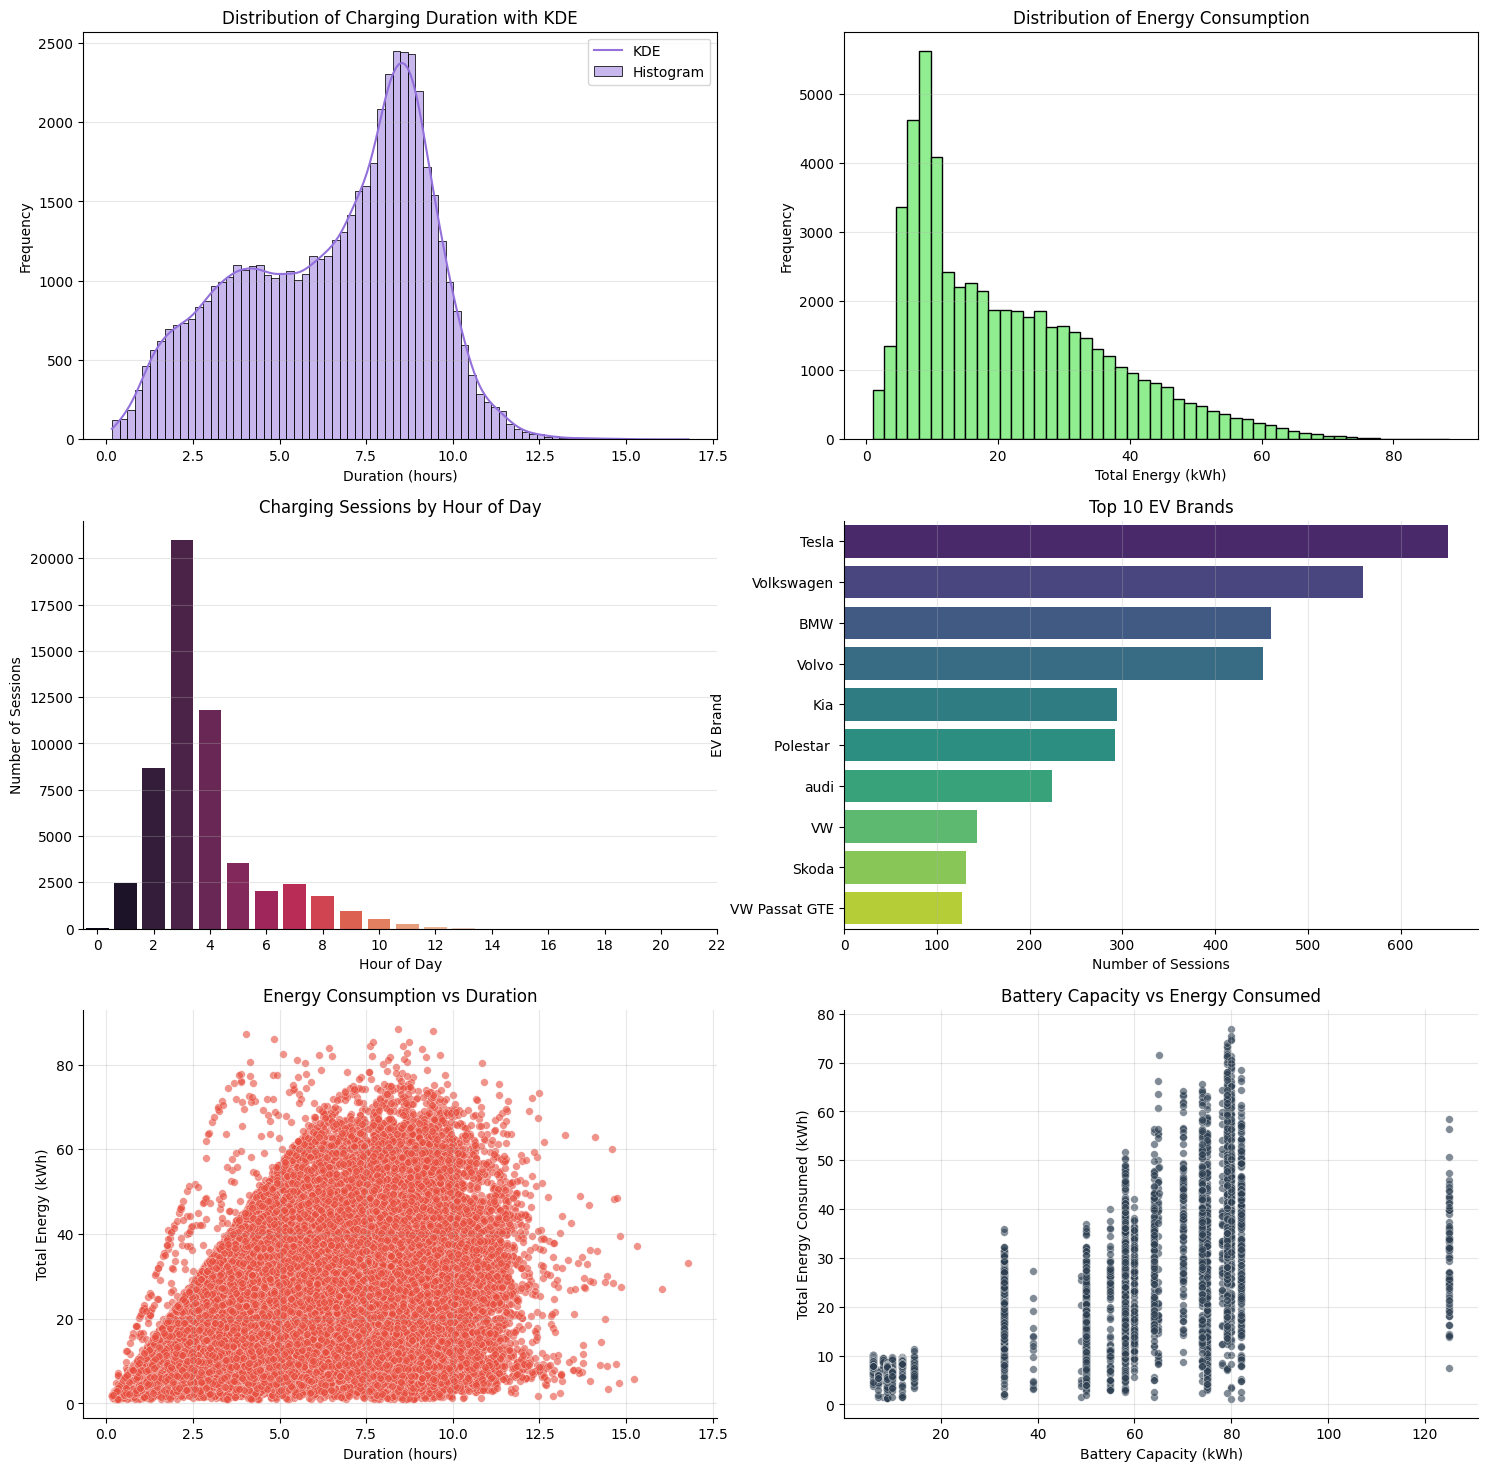

In [7]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(3, 2, figsize=(18, 18))

# 1. Distribution plot of duration
sns.histplot(data=df, x='duration', kde=True, ax=axes[0, 0], color='mediumpurple', edgecolor='black')
axes[0, 0].set_title('Distribution of Charging Duration with KDE')
axes[0, 0].set_xlabel('Duration (hours)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].legend(['KDE', 'Histogram'])

# 2. Distribution of total energy consumed
axes[0, 1].hist(df['total_energy'], bins=50, edgecolor='black', color='lightgreen')
axes[0, 1].set_xlabel('Total Energy (kWh)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Energy Consumption')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Charging sessions by hour of day
df['start_hour'] = df['start_datetime'].dt.hour
hourly_sessions = df['start_hour'].value_counts().sort_index()

sns.barplot(data=pd.DataFrame({'hour': hourly_sessions.index, 'sessions': hourly_sessions.values}),
            x='hour', y='sessions', hue='hour', 
            palette='rocket', ax=axes[1, 0], saturation=0.8, legend=False)

axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Number of Sessions')
axes[1, 0].set_title('Charging Sessions by Hour of Day')
axes[1, 0].set_xticks(range(0, 24, 2))
axes[1, 0].set_xticklabels(range(0, 24, 2))
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].spines['top'].set_visible(False)
axes[1, 0].spines['right'].set_visible(False)

# 4. Top EV brands
top_brands = df['EV_brand_selfreported'].value_counts().head(10)

sns.barplot(data=pd.DataFrame({'brand': top_brands.index, 'count': top_brands.values}),
            y='brand', x='count', hue='brand',
            palette='viridis', ax=axes[1, 1], saturation=0.8, legend=False)

axes[1, 1].set_xlabel('Number of Sessions')
axes[1, 1].set_ylabel('EV Brand')
axes[1, 1].set_title('Top 10 EV Brands')
axes[1, 1].grid(axis='x', alpha=0.3)
axes[1, 1].spines['top'].set_visible(False)
axes[1, 1].spines['right'].set_visible(False)

# 5. Energy vs Duration scatter plot
sns.scatterplot(x='duration', y='total_energy', data=df, 
                alpha=0.6, s=30, color='#e74c3c', 
                edgecolor='white', linewidth=0.3, ax=axes[2, 0])

# Styling
axes[2, 0].set_xlabel('Duration (hours)')
axes[2, 0].set_ylabel('Total Energy (kWh)')
axes[2, 0].set_title('Energy Consumption vs Duration')
axes[2, 0].grid(alpha=0.3)
axes[2, 0].spines['top'].set_visible(False)
axes[2, 0].spines['right'].set_visible(False)

# 6. Capacity vs Total Energy scatter
sns.scatterplot(x='capacity_kwh', y='total_energy', data=df, 
                alpha=0.6, s=30, color='#2c3e50', 
                edgecolor='white', linewidth=0.3, ax=axes[2, 1])

# Styling
axes[2, 1].set_xlabel('Battery Capacity (kWh)')
axes[2, 1].set_ylabel('Total Energy Consumed (kWh)')
axes[2, 1].set_title('Battery Capacity vs Energy Consumed')
axes[2, 1].grid(alpha=0.3)
axes[2, 1].spines['top'].set_visible(False)
axes[2, 1].spines['right'].set_visible(False)

## Correlation Matrix

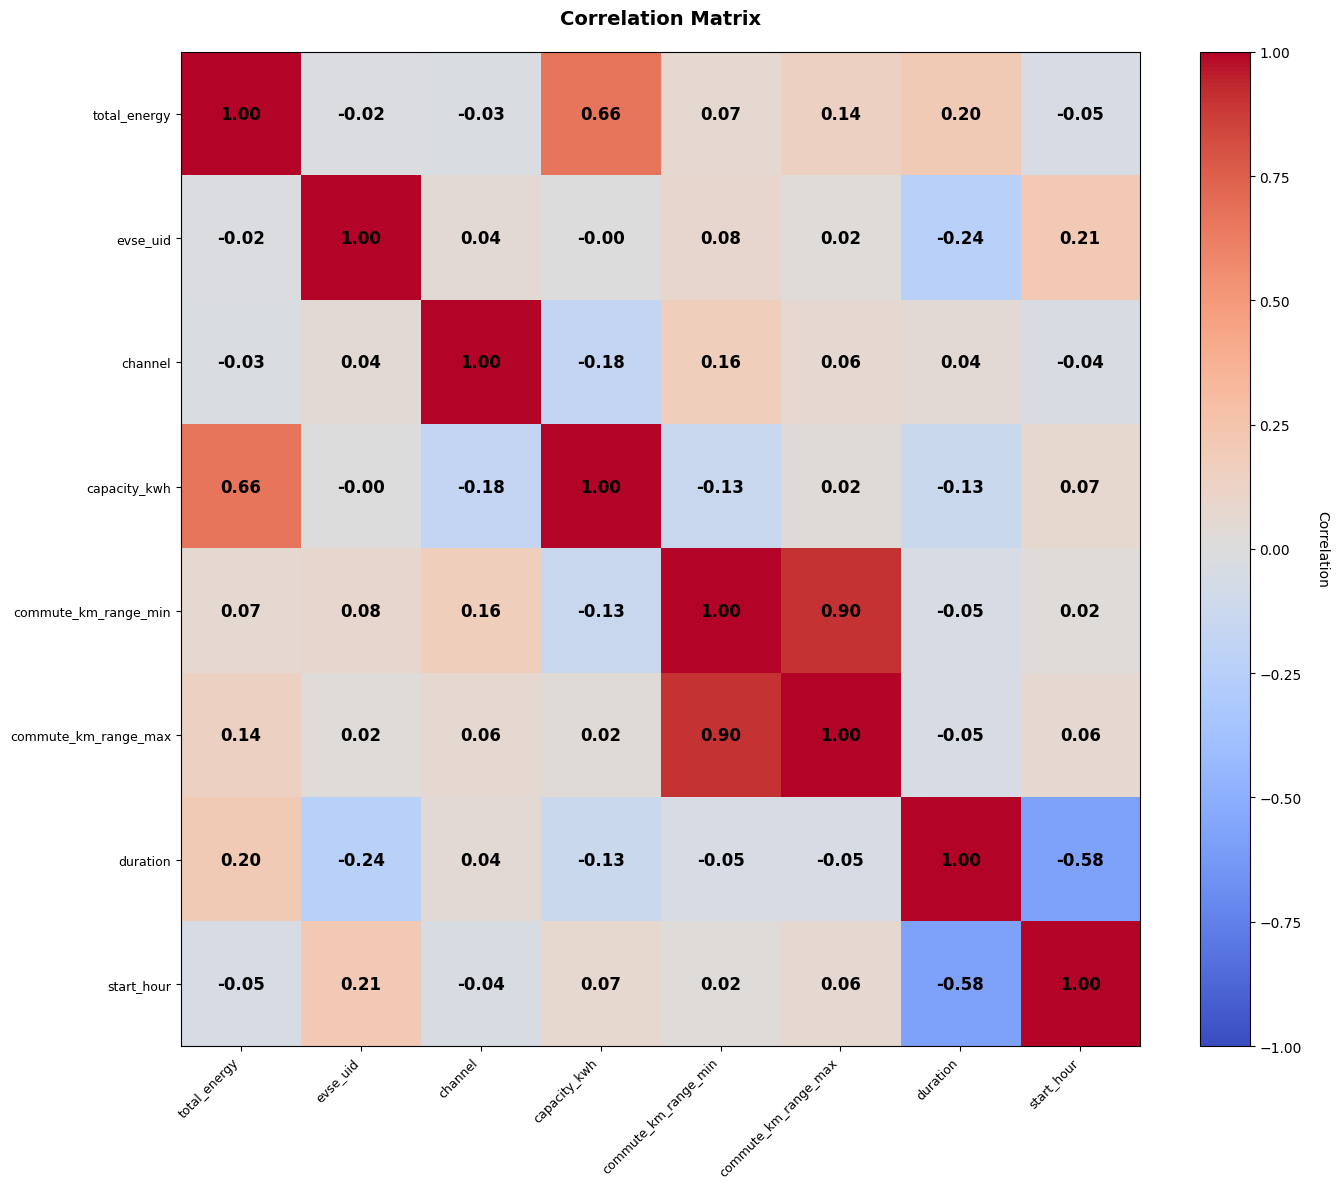

In [8]:

# Calculate correlation matrix for numeric columns
correlation_matrix = df.select_dtypes(include=['number']).corr()

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 12))

# Create the heatmap using imshow
im = ax.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')

# Set ticks and labels
ax.set_xticks(range(len(correlation_matrix.columns)))
ax.set_yticks(range(len(correlation_matrix.columns)))
ax.set_xticklabels(correlation_matrix.columns, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(correlation_matrix.columns, fontsize=9)

# Add text annotations for all values
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        text = ax.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                      ha="center", va="center", color="black", fontsize=12, weight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Correlation', rotation=270, labelpad=20)

ax.set_title('Correlation Matrix', fontsize=14, pad=20, weight='bold')
plt.tight_layout()
plt.show()

## ACF Plot

<Figure size 1000x400 with 0 Axes>

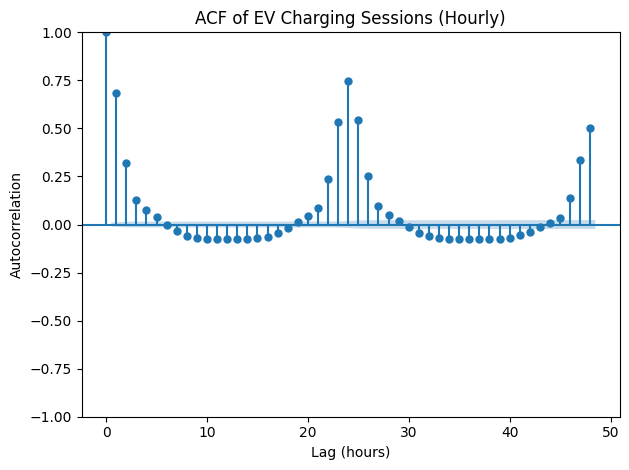

In [9]:
ts = (
    df
    .set_index('start_datetime')
    .resample('h')
    .size()
)

plt.figure(figsize=(10, 4))
plot_acf(ts, lags=48)
plt.title("ACF of EV Charging Sessions (Hourly)")
plt.xlabel("Lag (hours)")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.show()


# Dataset transformation

The code assumes that the charging power is constant throughout the session.$$\text{Average Power (kW)} = \frac{\text{Total Energy (kWh)}}{\text{Session Duration (h)}}$$

In [10]:
def create_time_series_optimized(df, group_col=None):
    """
    Converts charging session data into an hourly time series.
    Logic: Distributes energy proportionally based on the exact overlap 
    between the session duration and the specific hour.
    """    
    # 1. Calculate average power (kW) for each session
    df = df.copy()
    duration_h = (df['end_datetime'] - df['start_datetime']).dt.total_seconds() / 3600
    
    # Division by zero or extremely short durations
    df['avg_power_kw'] = np.where(duration_h > 0.001, df['total_energy'] / duration_h, 0)
    
    records = []
    
    # 2. iterate
    for row in df.itertuples():
        t_start = row.start_datetime
        t_end = row.end_datetime
        
        # Define the start and end hour buckets
        start_bucket = t_start.floor('h')
        end_bucket = t_end.ceil('h')
        
        # Generate all hourly timestamps involved in this session
        buckets = pd.date_range(start_bucket, end_bucket, freq='h', inclusive='left')
        
        for bucket in buckets:
            # Define the end of the current hour bucket
            bucket_end = bucket + pd.Timedelta(hours=1)
            
            # Calculate the exact time overlap in this specific hour
            # Overlap is the intersection: [max(start), min(end)]
            overlap_start = max(bucket, t_start)
            overlap_end = min(bucket_end, t_end)
            
            seconds_active = (overlap_end - overlap_start).total_seconds()
            
            if seconds_active > 0:
                hours_active = seconds_active / 3600
                
                # Energy = Time Active (h) * Power (kW)
                consumption = hours_active * row.avg_power_kw
                
                record = {
                    'timestamp': bucket,
                    'consumption': consumption,
                    'presence': 1  # flag (active during this hour ?)
                }
                
                # column (e.g., 'rail') if requested
                if group_col:
                    record[group_col] = getattr(row, group_col)
                    
                records.append(record)

    return pd.DataFrame(records)

In [11]:
print("\n" + "="*80)
print("CREATING TIME SERIES WITH REGULAR FREQUENCY (NO GAPS)")
print("="*80 + "\n")

# Generate the expanded dataset
df_expanded = create_time_series_optimized(df, group_col='rail')

# 1. Fleet TS (aggregation)
fleet_ts = df_expanded.groupby('timestamp').agg({
    'presence': 'sum',
    'consumption': 'sum'
}).resample('h').asfreq().fillna(0)

# Rename columns for consistency
fleet_ts.columns = ['presence', 'consumption']
fleet_ts = fleet_ts[['consumption', 'presence']]

# 2. Rail TS (Unstacking)
rail_ts = df_expanded.groupby(['timestamp', 'rail']).agg({
    'presence': 'sum',
    'consumption': 'sum'
}).unstack(fill_value=0)

print("-" * 80)
print("Transformation Complete.")
print(f"Fleet TS Shape: {fleet_ts.shape}")
print(f"Fleet TS frequency: {fleet_ts.index.freq}")
print("Fleet TS Head:")
print(fleet_ts.head())

print("\n--- Energy Conservation Check ---")

# Calculate totals
total_energy_raw = df['total_energy'].sum()
total_energy_ts = fleet_ts['consumption'].sum()
diff = total_energy_ts - total_energy_raw

print(f"Total Energy in Raw Dataset: {total_energy_raw:,.2f} kWh")
print(f"Total Energy in Time Series: {total_energy_ts:,.2f} kWh")
print(f"Difference: {diff:,.2f} kWh")

# Validation logic
if abs(diff) < 1.0:
    print("✅ Result: Energy is conserved perfectly.")
else:
    print("⚠️  Result: WARNING. Significant energy discrepancy found.")

print("\n" + "="*80 + "\n")



CREATING TIME SERIES WITH REGULAR FREQUENCY (NO GAPS)

--------------------------------------------------------------------------------
Transformation Complete.
Fleet TS Shape: (35982, 2)
Fleet TS frequency: <Hour>
Fleet TS Head:
                     consumption  presence
timestamp                                 
2020-08-25 11:00:00     0.479572       1.0
2020-08-25 12:00:00     4.503964       3.0
2020-08-25 13:00:00     3.920464       2.0
2020-08-25 14:00:00     7.184000       2.0
2020-08-25 15:00:00     0.000000       0.0

--- Energy Conservation Check ---
Total Energy in Raw Dataset: 1,193,202.00 kWh
Total Energy in Time Series: 1,193,202.00 kWh
Difference: 0.00 kWh
✅ Result: Energy is conserved perfectly.




In [12]:
# # Generate the new staset
# df_expanded = create_time_series_optimized(df, group_col='rail')

# # 1. Fleet TS (aggregation)
# fleet_ts = df_expanded.groupby('timestamp').agg({
#     'presence': 'sum',
#     'consumption': 'sum'
# }).resample('h').asfreq().fillna(0)

# # 2. Rail TS (Unstacking)
# rail_ts = df_expanded.groupby(['timestamp', 'rail']).agg({
#     'presence': 'sum',
#     'consumption': 'sum'
# }).unstack(fill_value=0)

# print("-" * 40)
# print("Transformation Complete.")
# print(f"Fleet TS Shape: {fleet_ts.shape}")
# print("Fleet TS Head:")
# print(fleet_ts.head())

# print("--- Energy Conservation Check ---")

# # Calculate totas
# total_energy_raw = df['total_energy'].sum()
# total_energy_ts = fleet_ts['consumption'].sum()
# diff = total_energy_ts - total_energy_raw

# print(f"Total Energy in Raw Dataset: {total_energy_raw:,.2f} kWh")
# print(f"Total Energy in Time Series: {total_energy_ts:,.2f} kWh")
# print(f"Difference: {diff:,.2f} kWh")

# # Validation logic
# if abs(diff) < 1.0:
#     print("Result: Energy is conserved perfectly.")
# else:
#     print("Result: WARNING. Significant energy discrepancy found.")

In [13]:
def prepare_features(df_ts):
    df = df_ts.copy()
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    # Lag features: the value from the previous hour or the previous day
    df['consumption_lag_24'] = df['consumption'].shift(24) # Consumo stessa ora ieri
    df['presence_lag_24'] = df['presence'].shift(24)
    
    return df.dropna()

fleet_features = prepare_features(fleet_ts)

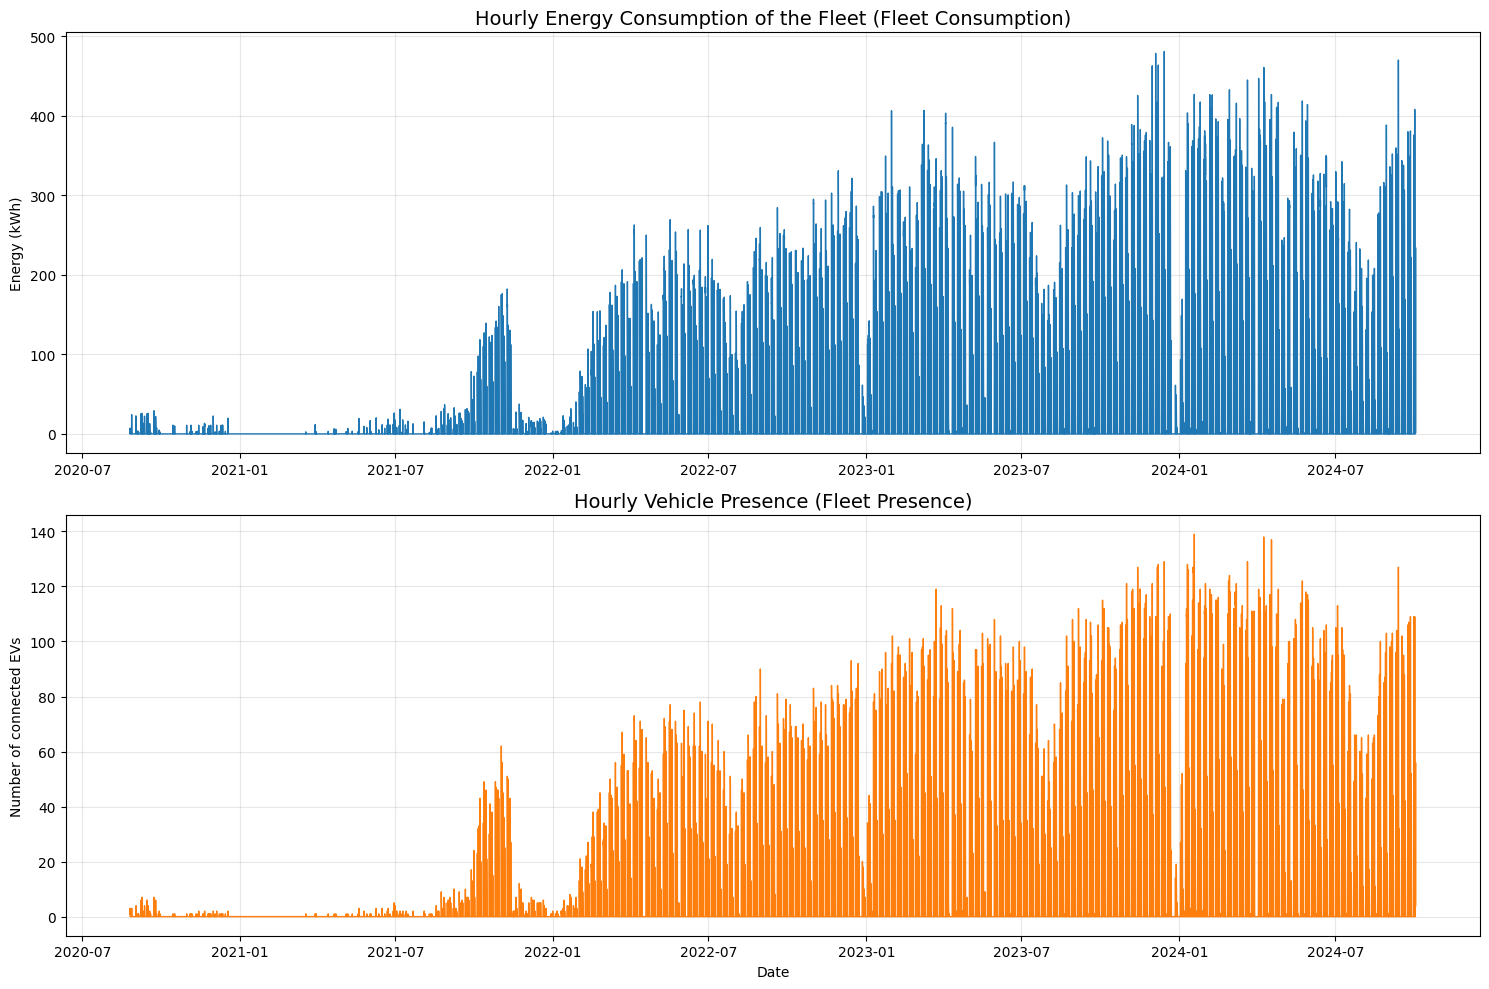

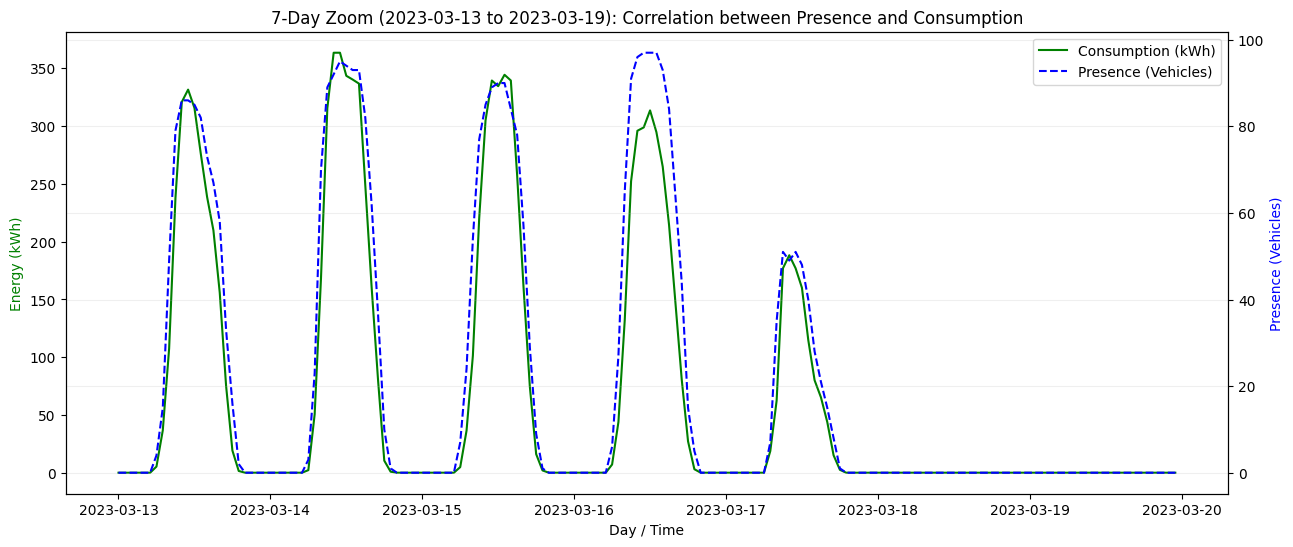

In [14]:
plt.figure(figsize=(15, 10))

# plot 1: total eergy consumption 
plt.subplot(2, 1, 1)
plt.plot(fleet_ts.index, fleet_ts['consumption'], color='tab:blue', linewidth=1)
plt.title('Hourly Energy Consumption of the Fleet (Fleet Consumption)', fontsize=14)
plt.ylabel('Energy (kWh)')
plt.grid(True, alpha=0.3)

# Plot 2: veichle presence
plt.subplot(2, 1, 2)
plt.plot(fleet_ts.index, fleet_ts['presence'], color='tab:orange', linewidth=1)
plt.title('Hourly Vehicle Presence (Fleet Presence)', fontsize=14)
plt.ylabel('Number of connected EVs')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# zoom to a  week in March 2023 
# from Mon 13 March to Sunday, 19th
start_date = '2023-03-13'
end_date = '2023-03-19'
sample_week = fleet_ts.loc[start_date:end_date]

fig, ax1 = plt.subplots(figsize=(15, 6))

ax2 = ax1.twinx()
# Consumption on the primary Y (left)
ax1.plot(sample_week.index, sample_week['consumption'], 'g-', label='Consumption (kWh)')
# Presence on the secondary Y (right)
ax2.plot(sample_week.index, sample_week['presence'], 'b--', label='Presence (Vehicles)')

ax1.set_xlabel('Day / Time')
ax1.set_ylabel('Energy (kWh)', color='g')
ax2.set_ylabel('Presence (Vehicles)', color='b')
plt.title(f'7-Day Zoom ({start_date} to {end_date}): Correlation between Presence and Consumption')
plt.grid(True, alpha=0.2)

# Combining legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.show()

In [15]:
for rail in ['B', 'C', 'E', 'H', 'J']:
    ts = rail_ts['consumption'][rail]
    train = ts.loc[:'2023-03-15 23:00:00']
    
    print(f"\nRail {rail}:")
    print(f"  Mean: {train.mean():.2f}")
    print(f"  Std: {train.std():.2f}")
    print(f"  Min: {train.min():.2f}")
    print(f"  Max: {train.max():.2f}")
    print(f"  CV (Std/Mean): {train.std()/train.mean():.4f}")
    print(f"  % zeros: {(train == 0).sum() / len(train) * 100:.1f}%")



Rail B:
  Mean: 14.47
  Std: 16.02
  Min: 0.00
  Max: 98.39
  CV (Std/Mean): 1.1068
  % zeros: 26.6%

Rail C:
  Mean: 4.47
  Std: 8.06
  Min: 0.00
  Max: 66.49
  CV (Std/Mean): 1.8038
  % zeros: 54.8%

Rail E:
  Mean: 20.68
  Std: 23.18
  Min: 0.00
  Max: 107.49
  CV (Std/Mean): 1.1206
  % zeros: 19.5%

Rail H:
  Mean: 18.50
  Std: 21.61
  Min: 0.00
  Max: 115.64
  CV (Std/Mean): 1.1682
  % zeros: 28.1%

Rail J:
  Mean: 4.16
  Std: 7.82
  Min: 0.00
  Max: 45.14
  CV (Std/Mean): 1.8771
  % zeros: 61.7%


## Stationary test

In [16]:
def check_stationarity_flexible(series, name, lags_to_test=[24, 168]):
    """
    Checks stationarity for Raw data, and then for specific Seasonal Lags.
    """
    print(f"======= Stationarity Analysis: {name} =======")
    
    # Helper function
    def run_tests(data, desc):
        # ADF Test 
        adf = adfuller(data.dropna(), autolag='AIC')
        
        # KPSS Test
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            kpss_res = kpss(data.dropna(), regression='c', nlags="auto")
            
        print(f'   ADF p-value:  {adf[1]:.4f}')
        print(f'   KPSS p-value: {kpss_res[1]:.4f}')
        
        is_stat = (adf[1] < 0.05) and (kpss_res[1] > 0.05)
        print(f"   Result: {'STATIONARY' if is_stat else 'NON-STATIONARY'}")
        return is_stat

    # 1. Test raw data
    if run_tests(series, "Raw Data"):
        print("Conclusion: Raw data is stationary.")
        print("=" * 60)
        return

    # 2. Test seasonal differences (24 and 168)
    for lag in lags_to_test:
        diff_series = series.diff(lag).dropna()
        if run_tests(diff_series, f"Seasonally Differenced (Lag {lag})"):
            print(f"\nConclusion: Series becomes stationary with Lag {lag} differencing.")
            print(f"Insight: The main cycle is {lag} hours.")
            print("=" * 60)
            return

    print("\nConclusion: Series is still non-stationary or complex.")
    print("=" * 60)

# test with boyh 1day (24h) and 1 week (168h)
check_stationarity_flexible(fleet_ts['consumption'], "Fleet Consumption", lags_to_test=[24, 168])

======= Stationarity Analysis: Fleet Consumption =======
   ADF p-value:  0.0000
   KPSS p-value: 0.0100
   Result: NON-STATIONARY
   ADF p-value:  0.0000
   KPSS p-value: 0.1000
   Result: STATIONARY

Conclusion: Series becomes stationary with Lag 24 differencing.
Insight: The main cycle is 24 hours.


Interpretation of Stationarity Tests
The stationarity analysis reveals a critical insight into the data structure:

Raw Data Conflict: The raw series shows conflicting results (ADF rejects unit root, but KPSS rejects stationarity). This is a classic signature of Seasonal Non-Stationarity. The mean is not constant because it follows a strong daily pattern (0 kWh at night, peak during the day).

Effect of Differencing: Applying a 24-hour seasonal difference (Lag 24) makes the series strictly stationary (KPSS p-value > 0.05). This confirms that the primary driver of the series is the daily cycle.

Modeling Strategy
Since the non-stationarity is driven by seasonality, we do not need to difference the target variable for the Machine Learning model (which would require complex inversion steps).

Instead, we will capture this structure by Feature Engineering:

We will introduce Lag Features (specifically Lag_24 and Lag_168) as input variables.

This allows the XGBoost model to learn the daily and weekly seasonality directly from the raw data, effectively "stationarizing" the problem internally without altering the target consumption values.

## Simple models

Functions

In [17]:
def cast_df(y, df):
    h = len(y)
    return pd.DataFrame(y, index=pd.date_range(
        start=df.index[-1] + pd.Timedelta(hours=1), periods=h, freq='h'))

def naive(x, h): 
    return cast_df(np.repeat(x.iloc[-1], h), x)

def mean_fc(x, h): 
    return cast_df(np.repeat(x.mean(), h), x)

def seasonal_naive(x, h, m=24):
    values = x.iloc[-m:].values
    y_hat = np.tile(values, int(np.ceil(h/m)))[:h]
    return cast_df(y_hat, x)

def calculate_nmae(y_true, y_pred, y_train_mean):
    # mae = np.mean(np.abs(y_true - y_pred))
    # mae_baseline = np.mean(np.abs(y_true - y_train_mean))
    # return mae / mae_baseline if mae_baseline != 0 else np.nan
    mae = np.mean(np.abs(y_true - y_pred))
    mae_baseline = np.mean(np.abs(y_true - np.mean(y_true)))  
    return mae / mae_baseline if mae_baseline != 0 else np.nan

In [18]:
def rolling_window_cv(ts_series, model_func, h_ahead=24, n_splits=10):
    """ time series CV w expanding window"""
    
    results = {'mae': [], 'nmae': [], 'actuals': [], 'forecasts': []}
    
    step = (len(ts_series) - h_ahead) // (n_splits + 1)
    
    for i in range(n_splits):
        train_end_idx = len(ts_series) - h_ahead - (n_splits - i) * step
        train = ts_series.iloc[:train_end_idx]
        test = ts_series.iloc[train_end_idx:train_end_idx + h_ahead]
        
        if len(test) < h_ahead:
            continue
        
        y_pred = model_func(train, h_ahead).values.ravel()
        y_true = test.values
        
        mae = np.mean(np.abs(y_true - y_pred))
        nmae = calculate_nmae(y_true, y_pred, train.mean())
        
        results['mae'].append(mae)
        results['nmae'].append(nmae)
        results['actuals'].append(y_true)
        results['forecasts'].append(y_pred)
    
    return results

# Benchmark for rails
def benchmark_per_rail(ts_data, target_name, split_date='2023-03-15 23:00:00', h_ahead=24):
    """Naive results for each rail"""
    
    print(f"\n{'='*55}")
    print(f"BENCHMARK NAIVE - {target_name.upper()}")
    print(f"{'='*55}")
    
    bench_results = {}
    split_datetime = pd.to_datetime(split_date)
    
    for rail in ts_data.columns:
        ts = ts_data[rail]
        train = ts.loc[:split_date]
        test = ts.loc[split_datetime + pd.Timedelta(hours=1):].iloc[:h_ahead]
        
        if len(test) < h_ahead:
            continue
        
        y_true = test.values
        
        # Forecasts
        y_naive = naive(train, h_ahead).values.ravel()
        y_mean = mean_fc(train, h_ahead).values.ravel()
        y_snai = seasonal_naive(train, h_ahead).values.ravel()
        
        # Metrics
        bench_results[rail] = {
            'Naive': calculate_nmae(y_true, y_naive, train.mean()),
            'Mean': calculate_nmae(y_true, y_mean, train.mean()),
            'S_Naive': calculate_nmae(y_true, y_snai, train.mean())
        }
    
    df_bench = pd.DataFrame(bench_results).T
    
    print(f"\nProcessed {len(bench_results)} rails\n")
    print(df_bench.round(4))
    print(f"\n{'-'*55}")
    print("Summary Statistics:")
    print(df_bench.describe().round(4))
    print(f"{'-'*55}\n")
    
    return df_bench


# Benchmark fleet
def benchmark_fleet(ts_series, target_name, split_date='2023-03-15 23:00:00', h_ahead=24):
    """Benchmark fleet level con rolling window CV + test set."""
    
    print(f"\n{'='*55}")
    print(f"BENCHMARK FLEET - {target_name.upper()}")
    print(f"{'='*55}\n")
    
    split_datetime = pd.to_datetime(split_date)
    
    # Cross-validation
    print("📊 ROLLING WINDOW CV (10 folds):")
    print(f"{'-'*55}")
    
    cv_naive = rolling_window_cv(ts_series, naive, h_ahead=h_ahead, n_splits=10)
    cv_mean = rolling_window_cv(ts_series, mean_fc, h_ahead=h_ahead, n_splits=10)
    cv_snai = rolling_window_cv(ts_series, seasonal_naive, h_ahead=h_ahead, n_splits=10)
    
    print(f"\nNaive   | MAE: {np.mean(cv_naive['mae']):.4f} ± {np.std(cv_naive['mae']):.4f} | "
          f"nMAE: {np.nanmean(cv_naive['nmae']):.4f} ± {np.nanstd(cv_naive['nmae']):.4f}")
    print(f"Mean    | MAE: {np.mean(cv_mean['mae']):.4f} ± {np.std(cv_mean['mae']):.4f} | "
          f"nMAE: {np.nanmean(cv_mean['nmae']):.4f} ± {np.nanstd(cv_mean['nmae']):.4f}")
    print(f"S_Naive | MAE: {np.mean(cv_snai['mae']):.4f} ± {np.std(cv_snai['mae']):.4f} | "
          f"nMAE: {np.nanmean(cv_snai['nmae']):.4f} ± {np.nanstd(cv_snai['nmae']):.4f}")
    
    # Test set
    print(f"\n{'-'*55}")
    print(f"📋 TEST SET ({split_date}):")
    print(f"{'-'*55}\n")
    
    train = ts_series.loc[:split_date]
    test = ts_series.loc[split_datetime + pd.Timedelta(hours=1):].iloc[:h_ahead]
    
    if len(test) >= h_ahead:
        y_true = test.values
        
        y_naive = naive(train, h_ahead).values.ravel()
        y_mean = mean_fc(train, h_ahead).values.ravel()
        y_snai = seasonal_naive(train, h_ahead).values.ravel()
        
        nmae_naive = calculate_nmae(y_true, y_naive, train.mean())
        nmae_mean = calculate_nmae(y_true, y_mean, train.mean())
        nmae_snai = calculate_nmae(y_true, y_snai, train.mean())
        
        print(f"Naive   nMAE: {nmae_naive:.4f}")
        print(f"Mean    nMAE: {nmae_mean:.4f}")
        print(f"S_Naive nMAE: {nmae_snai:.4f} ← BASELINE\n")


def plot_fleet_forecast(ts_series, split_date='2023-03-15 23:00:00', h_ahead=24, target_name='Consumption'):
    """Plot fleet forecast vs actual."""
    
    split_datetime = pd.to_datetime(split_date)
    train = ts_series.loc[:split_date]
    test = ts_series.loc[split_datetime + pd.Timedelta(hours=1):].iloc[:h_ahead]
    
    y_naive = naive(train, h_ahead).values.ravel()
    y_mean = mean_fc(train, h_ahead).values.ravel()
    y_snai = seasonal_naive(train, h_ahead).values.ravel()
    
    fig, ax = plt.subplots(figsize=(14, 6))
    hours = np.arange(h_ahead)
    
    ax.plot(hours, test.values, marker='o', label='Actual', linewidth=2.5, 
            color='black', markersize=6, zorder=5)
    ax.plot(hours, y_naive, linestyle='--', label='Naive', linewidth=1.8, alpha=0.8)
    ax.plot(hours, y_mean, linestyle='--', label='Mean', linewidth=1.8, alpha=0.8)
    ax.plot(hours, y_snai, linestyle='--', label='S_Naive', linewidth=1.8, alpha=0.8)
    
    ax.set_title(f'Fleet {target_name}: 24h Ahead Forecast', fontsize=13, fontweight='bold')
    ax.set_xlabel('Hour Ahead', fontsize=11)
    ax.set_ylabel(f'{target_name}', fontsize=11)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(0, h_ahead, 3))
    
    plt.tight_layout()
    return fig


# 6. PROBABILISTIC FORECAST
def compute_prediction_intervals(ts_series, model_func, split_date='2023-03-15 23:00:00', 
                                 h_ahead=24, n_splits=10, quantiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]):
    """Prediction intervals from residuals"""
    
    split_datetime = pd.to_datetime(split_date)
    all_residuals = []
    
    step = (len(ts_series) - h_ahead) // (n_splits + 1)
    
    for i in range(n_splits):
        train_end_idx = len(ts_series) - h_ahead - (n_splits - i) * step
        train = ts_series.iloc[:train_end_idx]
        test = ts_series.iloc[train_end_idx:train_end_idx + h_ahead]
        
        if len(test) < h_ahead:
            continue
        
        y_pred = model_func(train, h_ahead).values.ravel()
        y_true = test.values
        
        residuals = y_true - y_pred
        all_residuals.append(residuals)
    
    all_residuals = np.concatenate(all_residuals)
    
    quantile_dict = {}
    for q in quantiles:
        quantile_dict[f'q{int(q*100)}'] = np.quantile(all_residuals, q)
    
    return {
        'residuals': all_residuals,
        'mean_residual': np.mean(all_residuals),
        'std_residual': np.std(all_residuals),
        'quantiles': quantile_dict
    }


def probabilistic_forecast_fleet(ts_series, target_name='Consumption', 
                                 split_date='2023-03-15 23:00:00', h_ahead=24):
    """General probability forecasts for the fleet"""
    
    print(f"\n{'='*55}")
    print(f"PROBABILISTIC FORECAST - {target_name.upper()}")
    print(f"{'='*55}\n")
    
    split_datetime = pd.to_datetime(split_date)
    train = ts_series.loc[:split_date]
    test = ts_series.loc[split_datetime + pd.Timedelta(hours=1):].iloc[:h_ahead]
    
    # Point forecast
    y_point = seasonal_naive(train, h_ahead).values.ravel()
    
    # Compute residual distribution
    residual_stats = compute_prediction_intervals(
        ts_series, seasonal_naive, split_date, h_ahead, n_splits=10
    )
    
    # Prediction intervals
    lower_5 = y_point + residual_stats['quantiles']['q5']
    lower_10 = y_point + residual_stats['quantiles']['q10']
    lower_25 = y_point + residual_stats['quantiles']['q25']
    median_pred = y_point + residual_stats['quantiles']['q50']
    upper_25 = y_point + residual_stats['quantiles']['q75']
    upper_10 = y_point + residual_stats['quantiles']['q90']
    upper_95 = y_point + residual_stats['quantiles']['q95']
    
    print(f"Residual Distribution Stats:")
    print(f"  Mean: {residual_stats['mean_residual']:.4f}")
    print(f"  Std:  {residual_stats['std_residual']:.4f}")
    print(f"\nPrediction Intervals (from residuals):")
    for q_name, q_val in residual_stats['quantiles'].items():
        print(f"  {q_name}: {q_val:.4f}")
    
    return {
        'point_forecast': y_point,
        'median_pred': median_pred,
        'lower_5': lower_5,
        'lower_10': lower_10,
        'lower_25': lower_25,
        'upper_25': upper_25,
        'upper_10': upper_10,
        'upper_95': upper_95,
        'actual': test.values,
        'residual_stats': residual_stats
    }


def plot_probabilistic_forecast(ts_series, target_name='Consumption', split_date='2023-03-15 23:00:00', h_ahead=24):
    """Plot fan chart con prediction intervals."""
    
    fc = probabilistic_forecast_fleet(ts_series, target_name, split_date, h_ahead)
    
    hours = np.arange(h_ahead)
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Fan chart
    ax.fill_between(hours, fc['lower_5'], fc['upper_95'], alpha=0.1, 
                    color='blue', label='90% PI (5%-95%)')
    ax.fill_between(hours, fc['lower_10'], fc['upper_10'], alpha=0.15, 
                    color='blue', label='80% PI (10%-90%)')
    ax.fill_between(hours, fc['lower_25'], fc['upper_25'], alpha=0.2, 
                    color='blue', label='50% PI (25%-75%)')
    
    ax.plot(hours, fc['point_forecast'], color='blue', linewidth=2.5, 
            label='Point Forecast (S_Naive)', zorder=4)
    ax.plot(hours, fc['median_pred'], color='cyan', linewidth=1.5, 
            linestyle=':', label='Median Forecast', zorder=3)
    ax.plot(hours, fc['actual'], marker='o', color='black', linewidth=2.5, 
            markersize=6, label='Actual', zorder=5)
    
    ax.set_title(f'{target_name}: Probabilistic 24h Forecast (Fan Chart)', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Hour Ahead', fontsize=12)
    ax.set_ylabel(f'{target_name} (units)', fontsize=12)
    ax.legend(loc='best', fontsize=10, framealpha=0.95)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(0, h_ahead, 2))
    
    plt.tight_layout()
    return fig, fc


def print_probabilistic_summary(fc_result, h_ahead=24):
    """Print report of prob forecasting"""
    
    print(f"\n{'='*55}")
    print("PROBABILISTIC FORECAST - DETAILED RESULTS")
    print(f"{'='*55}\n")
    
    print(f"{'Hour':>6} {'Actual':>10} {'Point':>10} {'5%':>10} {'10%':>10} {'Median':>10} {'90%':>10} {'95%':>10}")
    print(f"{'-'*55}")
    
    for i in range(h_ahead):
        print(f"{i:6d} {fc_result['actual'][i]:10.2f} {fc_result['point_forecast'][i]:10.2f} "
              f"{fc_result['lower_5'][i]:10.2f} {fc_result['lower_10'][i]:10.2f} "
              f"{fc_result['median_pred'][i]:10.2f} {fc_result['upper_10'][i]:10.2f} "
              f"{fc_result['upper_95'][i]:10.2f}")
    
    print(f"\n{'='*55}")
    print("COVERAGE ANALYSIS")
    print(f"{'='*55}\n")
    
    coverage_80 = np.sum((fc_result['actual'] >= fc_result['lower_10']) & 
                         (fc_result['actual'] <= fc_result['upper_10']))
    coverage_90 = np.sum((fc_result['actual'] >= fc_result['lower_5']) & 
                         (fc_result['actual'] <= fc_result['upper_95']))
    
    print(f"80% PI Coverage: {coverage_80}/{h_ahead} = {100*coverage_80/h_ahead:.1f}%")
    print(f"90% PI Coverage: {coverage_90}/{h_ahead} = {100*coverage_90/h_ahead:.1f}%")
    
    width_80 = np.mean(fc_result['upper_10'] - fc_result['lower_10'])
    width_90 = np.mean(fc_result['upper_95'] - fc_result['lower_5'])
    
    print(f"\n80% PI Avg Width: {width_80:.2f}")
    print(f"90% PI Avg Width: {width_90:.2f}")



BENCHMARK NAIVE - CONSUMPTION

Processed 15 rails

                               Naive    Mean  S_Naive
B                             1.4120  1.0037   1.1300
C                             1.2881  1.0234   2.1206
E                             1.7577  1.0331   1.9520
H                             1.7259  1.0821   1.8011
J                             1.3211  1.1017   1.0633
K                                NaN     NaN      NaN
L                                NaN     NaN      NaN
M                             1.1346  0.9818   2.0919
carport groot                    NaN     NaN      NaN
carport klein                    NaN     NaN      NaN
mennekes                      1.5419  1.0186   1.5335
shared car                    1.0077  1.0039   1.3358
visitors                      1.0010  0.9906   1.3690
visitors facility management     NaN     NaN      NaN
wheelchair parking               NaN     NaN      NaN

-------------------------------------------------------
Summary Statistics:
       

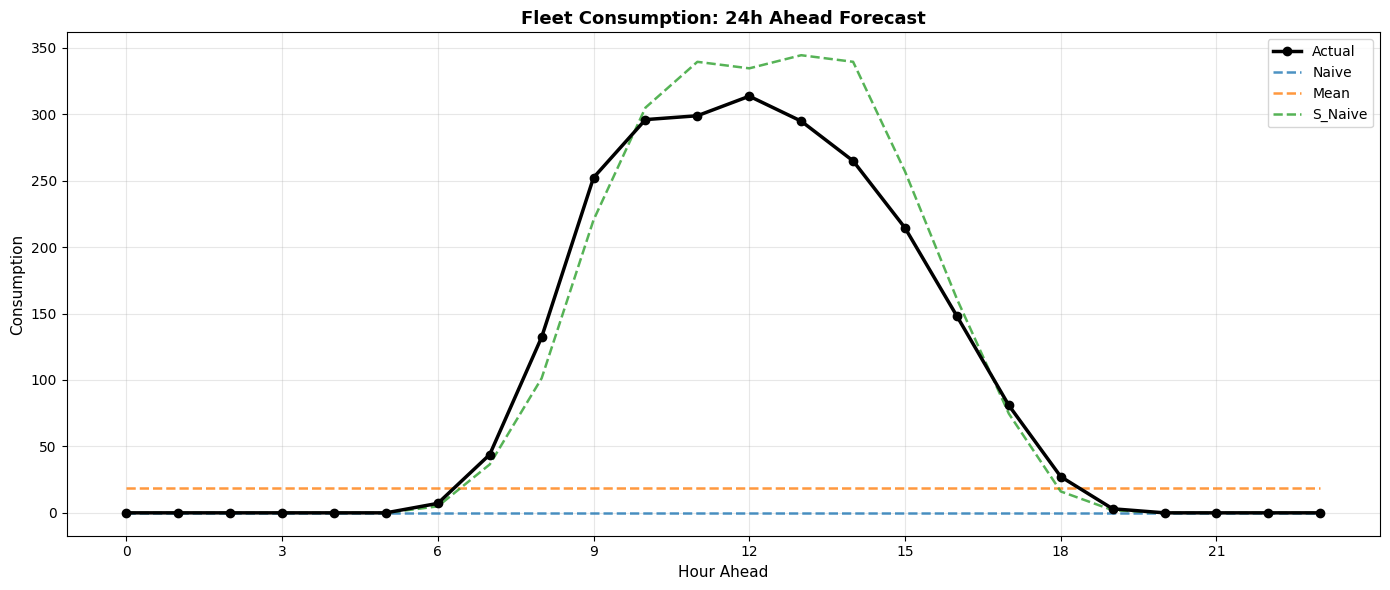

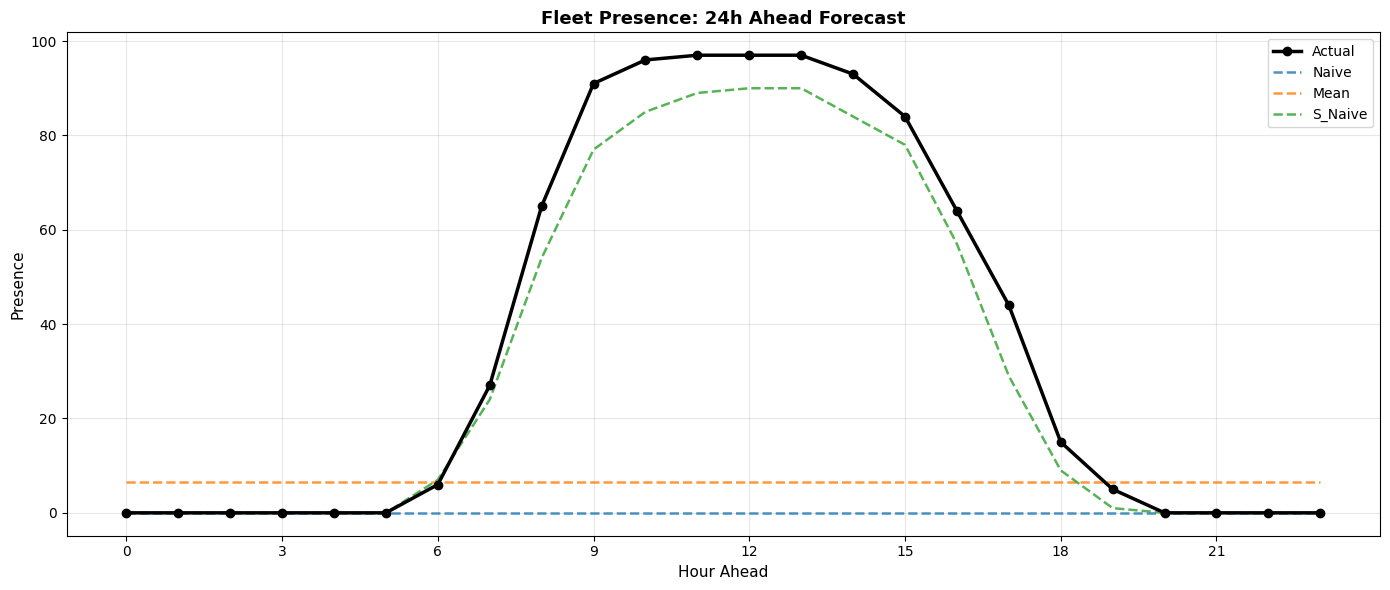

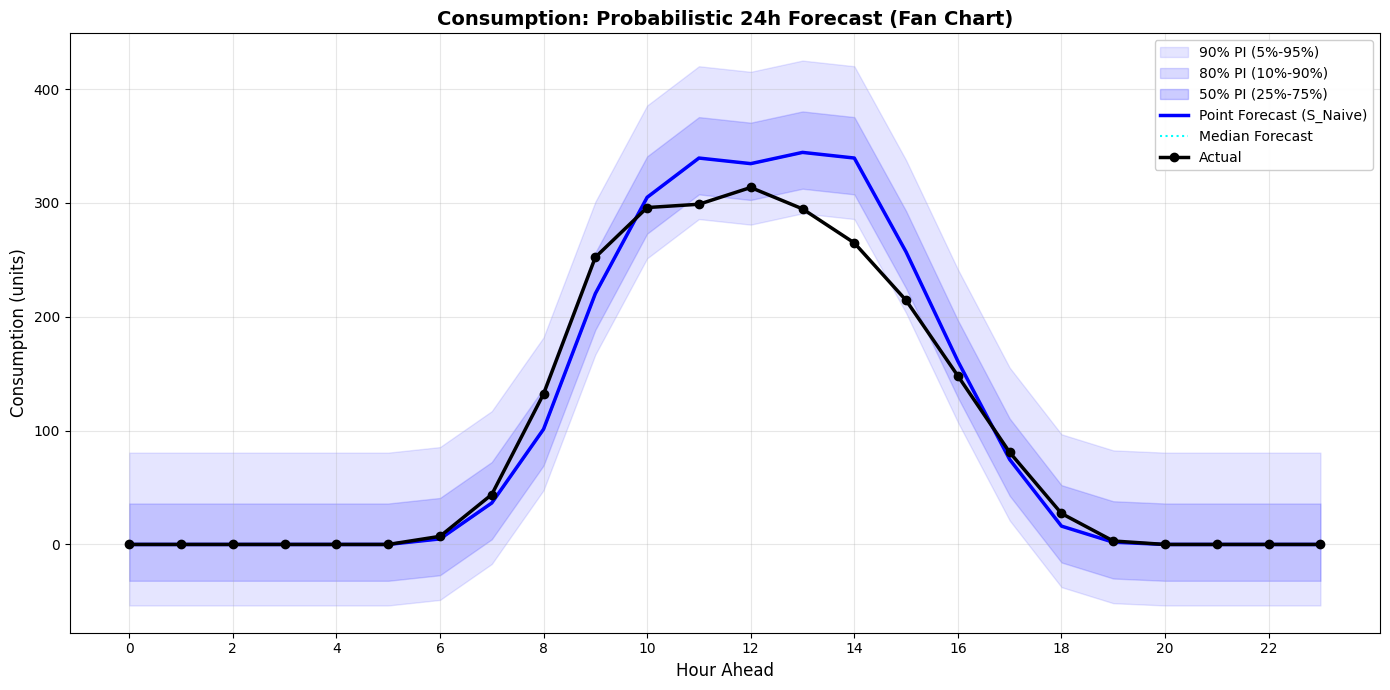

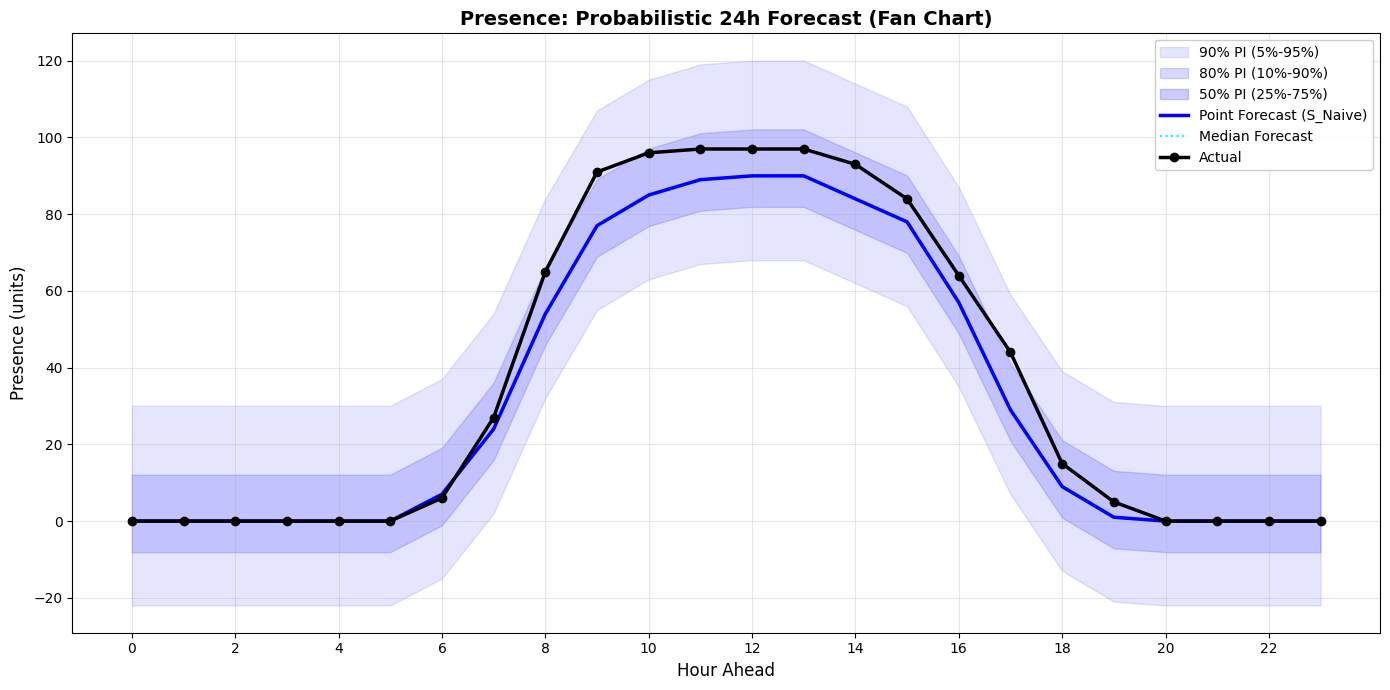

In [19]:
# 1. Benchmark rail
bench_c = benchmark_per_rail(rail_ts['consumption'], 'consumption')
bench_p = benchmark_per_rail(rail_ts['presence'], 'presence')

# 2. Benchmark fleet
benchmark_fleet(fleet_ts['consumption'], 'consumption')
benchmark_fleet(fleet_ts['presence'], 'presence')

# 3. Plot
fig1 = plot_fleet_forecast(fleet_ts['consumption'], target_name='Consumption')
fig2 = plot_fleet_forecast(fleet_ts['presence'], target_name='Presence')

# 4. Probabilistic forecasts
fig_prob_c, fc_c = plot_probabilistic_forecast(fleet_ts['consumption'], target_name='Consumption')
print_probabilistic_summary(fc_c)

fig_prob_p, fc_p = plot_probabilistic_forecast(fleet_ts['presence'], target_name='Presence')
print_probabilistic_summary(fc_p)

plt.show()

# ML models
chronos 2 adattato dal codice del prof

In [20]:
def train_chronos2(fleet_ts, target_name='consumption', split_date='2023-03-15 23:00:00', h_ahead=24):
    """
    Usa Chronos 2 come nel codice del prof.
    Adattato per EV forecasting.
    """
    
    try:
        pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-2", device_map="cpu")
    except Exception as e:
        print(f"⚠️  Failed to load Chronos 2: {str(e)[:100]}")
        return None
    
    print(f"\n{'='*80}")
    print(f"TRAINING CHRONOS 2 - {target_name.upper()}")
    print(f"{'='*80}\n")
    
    split_datetime = pd.to_datetime(split_date)
    train = fleet_ts.loc[:split_date]
    test = fleet_ts.loc[split_datetime + pd.Timedelta(hours=1):].iloc[:h_ahead]
    
    if len(test) < h_ahead:
        print("⚠️  Test set too short")
        return None
    
    try:
        print("Loading Chronos 2 pipeline...")
        print(f"Making predictions with context of {len(train)} samples...\n")
        
        # Prepara dati come nel prof (con timestamp e item_id)
        df_context = pd.DataFrame({
            'Date Time': train.index,
            'item_id': 'ev_fleet',
            target_name: train.values
        }).reset_index(drop=True)
        
        # Quantiles
        cron_qs = [0.1, 0.25, 0.5, 0.75, 0.9]
        
        # Predici con predict_df (come nel prof)
        cron_pred_df = pipeline.predict_df(
            df_context,
            prediction_length=h_ahead,
            quantile_levels=cron_qs,
            id_column="item_id",
            timestamp_column="Date Time",
            target=target_name,
        )
        
        # Estrai le previsioni (mediana = 0.5 quantile)
        y_chronos = cron_pred_df['0.5'].values  # Mediana
        
        # Calcola metriche
        y_test = test.values
        mae = mean_absolute_error(y_test, y_chronos)
        nmae = calculate_nmae(y_test, y_chronos, train.mean())
        
        print(f"MAE:  {mae:.4f}")
        print(f"nMAE: {nmae:.4f}\n")
        
        return {
            'pipeline': pipeline,
            'y_pred': y_chronos,
            'y_test': y_test,
            'mae': mae,
            'nmae': nmae,
            'predictions_df': cron_pred_df
        }
    
    except Exception as e:
        print(f"⚠️  Chronos 2 prediction failed: {str(e)[:150]}\n")
        return None


# ============================================================================
# COMPARE CON CHRONOS 2 (STILE PROF)
# ============================================================================

def compare_all_models_w_chronos2(fleet_ts, target_name='Consumption', split_date='2023-03-15 23:00:00'):
    """
    Confronta: S_Naive + ARIMA + Chronos2 (STILE PROF)
    """
    
    print(f"\n{'#'*80}")
    print(f"# FINAL MODEL COMPARISON - {target_name.upper()}")
    print(f"{'#'*80}\n")
    
    split_datetime = pd.to_datetime(split_date)
    train = fleet_ts.loc[:split_date]
    test = fleet_ts.loc[split_datetime + pd.Timedelta(hours=1):].iloc[:24]
    
    y_test = test.values
    y_train_mean = train.mean()
    
    results = {}
    
    # 1. BASELINE (Seasonal Naive)
    print("1️⃣  Seasonal Naive (BASELINE):")
    y_snai = seasonal_naive(train, 24).values.ravel()
    mae_snai = mean_absolute_error(y_test, y_snai)
    nmae_snai = calculate_nmae(y_test, y_snai, y_train_mean)
    
    print(f"   MAE:  {mae_snai:.4f}")
    print(f"   nMAE: {nmae_snai:.4f}\n")
    
    results['S_Naive'] = {'mae': mae_snai, 'nmae': nmae_snai}
    
    # 2. ARIMA
    print("2️⃣  ARIMA(2,1,2):")
    try:
        from statsmodels.tsa.arima.model import ARIMA
        
        model = ARIMA(train, order=(2, 1, 2))
        model_fit = model.fit()
        y_arima = model_fit.forecast(steps=24).values
        
        mae_arima = mean_absolute_error(y_test, y_arima)
        nmae_arima = calculate_nmae(y_test, y_arima, y_train_mean)
        
        print(f"   MAE:  {mae_arima:.4f}")
        print(f"   nMAE: {nmae_arima:.4f}\n")
        
        results['ARIMA(2,1,2)'] = {'mae': mae_arima, 'nmae': nmae_arima}
    except Exception as e:
        print(f"   ⚠️  Failed: {str(e)[:50]}\n")
    
    # 3. CHRONOS 2 (STILE PROF)
    print("3️⃣  Chronos 2 (SOTA - Foundation Model):")
    chronos_result = train_chronos2(fleet_ts, target_name=target_name.lower(), split_date=split_date)
    
    if chronos_result:
        results['Chronos2'] = {'mae': chronos_result['mae'], 'nmae': chronos_result['nmae']}
    
    # COMPARISON
    print("="*80)
    print("FINAL COMPARISON - nMAE")
    print("="*80 + "\n")
    
    df_results = pd.DataFrame(results).T
    df_results = df_results.sort_values('nmae')
    print(df_results.round(4))
    
    best_model = df_results.index[0]
    best_nmae = df_results['nmae'].iloc[0]
    baseline_nmae = results['S_Naive']['nmae']
    improvement = ((baseline_nmae - best_nmae) / baseline_nmae * 100) if baseline_nmae != 0 else 0
    
    print(f"\n{'='*80}")
    print(f"✅ BEST MODEL: {best_model}")
    print(f"   nMAE: {best_nmae:.4f} (Baseline: {baseline_nmae:.4f})")
    print(f"   Improvement: {improvement:+.2f}%")
    print(f"{'='*80}\n")
    
    return results, df_results


# ============================================================================
# EXECUTION
# ============================================================================

results_c, df_c = compare_all_models_w_chronos2(fleet_ts['consumption'], 'Consumption')
results_p, df_p = compare_all_models_w_chronos2(fleet_ts['presence'], 'Presence')



################################################################################
# FINAL MODEL COMPARISON - CONSUMPTION
################################################################################

1️⃣  Seasonal Naive (BASELINE):
   MAE:  14.2090
   nMAE: 0.1288

2️⃣  ARIMA(2,1,2):
   MAE:  93.0789
   nMAE: 0.8439

3️⃣  Chronos 2 (SOTA - Foundation Model):

TRAINING CHRONOS 2 - CONSUMPTION

Loading Chronos 2 pipeline...
Making predictions with context of 22381 samples...

MAE:  5.6691
nMAE: 0.0514

FINAL COMPARISON - nMAE

                  mae    nmae
Chronos2       5.6691  0.0514
S_Naive       14.2090  0.1288
ARIMA(2,1,2)  93.0789  0.8439

✅ BEST MODEL: Chronos2
   nMAE: 0.0514 (Baseline: 0.1288)
   Improvement: +60.10%


################################################################################
# FINAL MODEL COMPARISON - PRESENCE
################################################################################

1️⃣  Seasonal Naive (BASELINE):
   MAE:  4.5417
   nMAE: 0.118

TEST


CHRONOS 2 - COMPLETE FORECASTING PIPELINE

################################################################################
# SECTION 1: FLEET-LEVEL MODEL COMPARISON
################################################################################

################################################################################
# FINAL MODEL COMPARISON - CONSUMPTION
################################################################################

1️⃣  Seasonal Naive (BASELINE):
   MAE:  14.2090
   nMAE: 0.1288

2️⃣  ARIMA(2,1,2):
   MAE:  93.0789
   nMAE: 0.8439

3️⃣  Chronos 2 (SOTA - Foundation Model):

TRAINING CHRONOS 2 - CONSUMPTION

Loading Chronos 2 pipeline...
Making predictions with context of 22381 samples...

MAE:  5.6691
nMAE: 0.0514

FINAL COMPARISON - nMAE

                  mae    nmae
Chronos2       5.6691  0.0514
S_Naive       14.2090  0.1288
ARIMA(2,1,2)  93.0789  0.8439

✅ BEST MODEL: Chronos2
   nMAE: 0.0514 (Baseline: 0.1288)
   Improvement: +60.10%


#############

Processing rails: 100%|██████████| 15/15 [00:00<00:00, 222.22it/s]


⚠️  No valid results for any rail!

Processed 15 rails (0 valid)

--------------------------------------------------------------------------------


CHRONOS 2 PER RAIL - PRESENCE



Processing rails: 100%|██████████| 15/15 [00:00<00:00, 98.08it/s]


⚠️  No valid results for any rail!

Processed 15 rails (0 valid)

--------------------------------------------------------------------------------


################################################################################
# SECTION 3: PROBABILISTIC FORECAST - CHRONOS 2
################################################################################

PROBABILISTIC FORECAST - CHRONOS 2 - CONSUMPTION

Quantile Range:
  5%-95%:  [60.6773, 136.2773]
  10%-90%: [75.1771, 127.9272]
  25%-75%: [90.4462, 115.1607]


PROBABILISTIC FORECAST - CHRONOS 2 - DETAILED RESULTS

  Hour     Actual         5%        10%        50%        90%        95%
--------------------------------------------------------------------------------
     0       0.00      -1.29      -0.37       2.11       4.44       5.26
     1       0.00      -1.26      -0.15       2.17       4.30       4.99
     2       0.00      -0.42       0.54       2.59       4.49       4.80
     3       0.00       0.35       0.87       2.31 

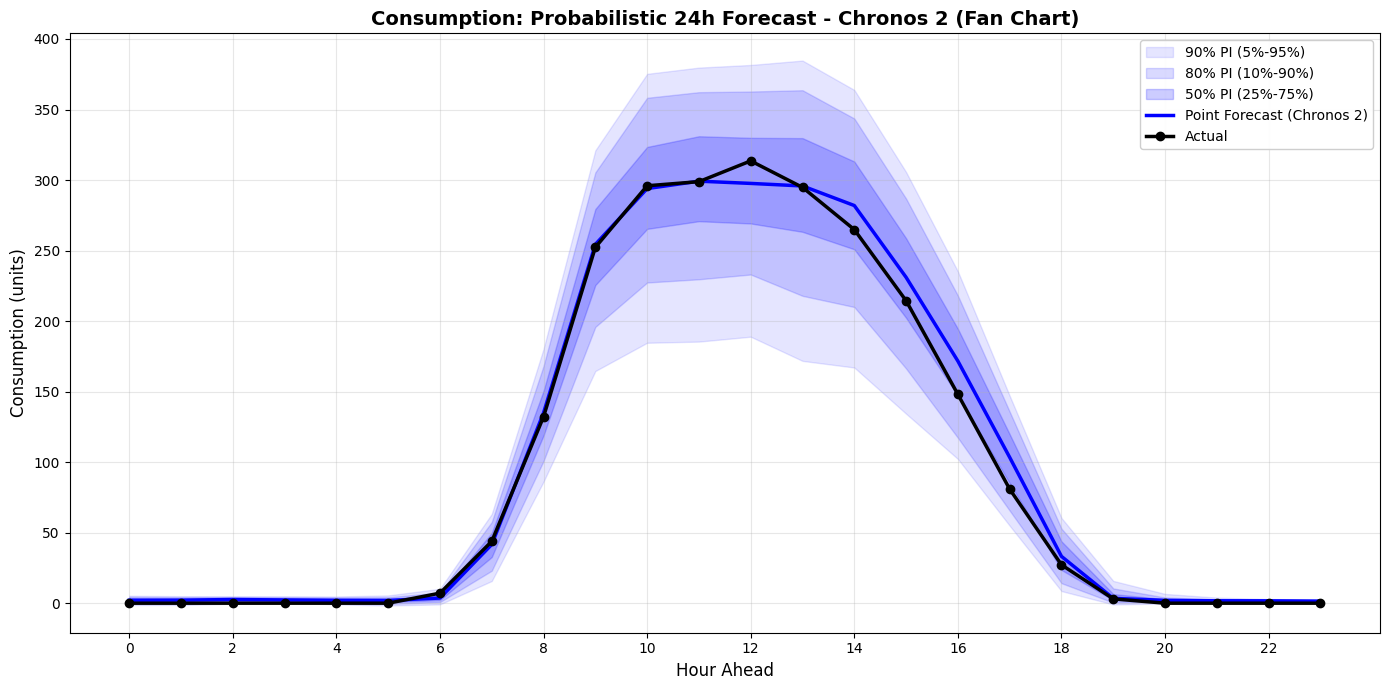

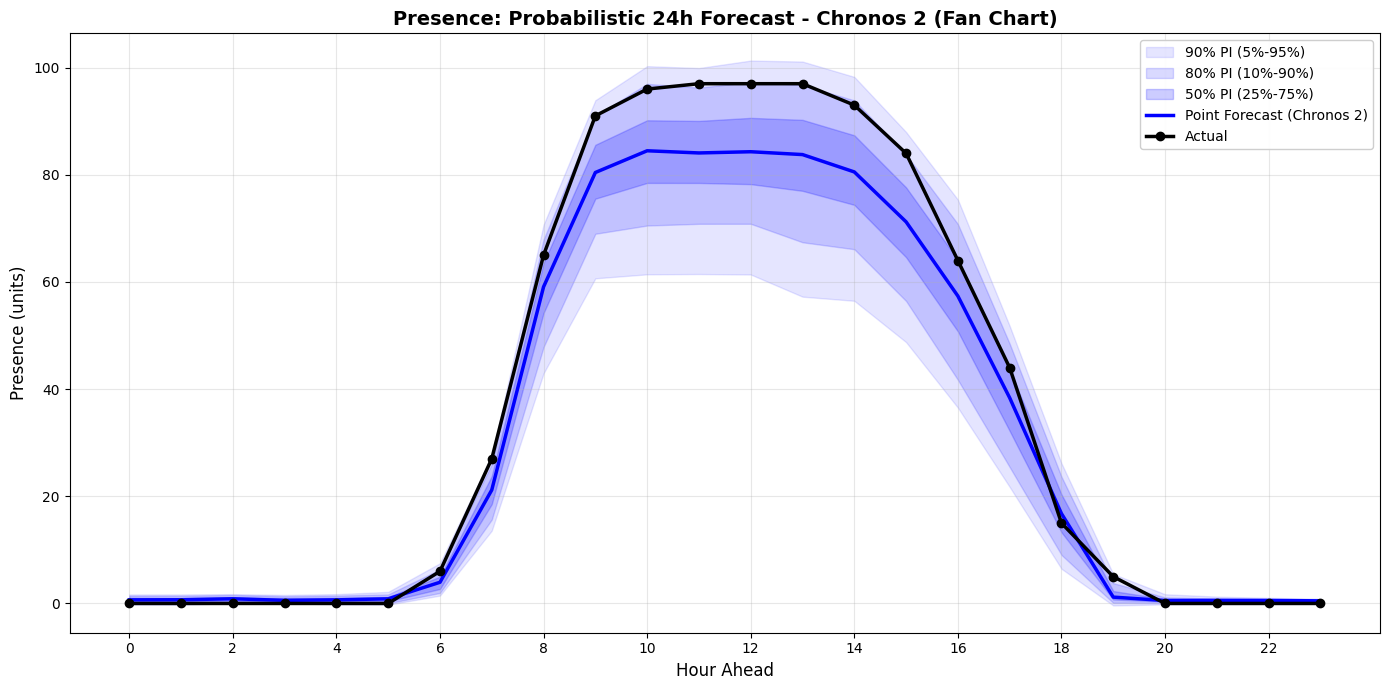


✅ PIPELINE COMPLETE



In [21]:
# ============================================================================
# CHRONOS 2 - COMPLETE SOLUTION WITH PER-RAIL & PROBABILISTIC FORECAST
# ============================================================================

from chronos import BaseChronosPipeline
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt


# ============================================================================
# 1. CHRONOS 2 FOR FLEET (OVERALL)
# ============================================================================

def train_chronos2_prof_style(fleet_ts, target_name='consumption', split_date='2023-03-15 23:00:00', h_ahead=24):
    """Chronos 2 for fleet-level forecasting."""
    
    try:
        pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-2", device_map="cpu")
    except Exception as e:
        print(f"⚠️  Failed to load Chronos 2: {str(e)[:100]}")
        return None
    
    print(f"\n{'='*80}")
    print(f"TRAINING CHRONOS 2 - {target_name.upper()}")
    print(f"{'='*80}\n")
    
    split_datetime = pd.to_datetime(split_date)
    train = fleet_ts.loc[:split_date]
    test = fleet_ts.loc[split_datetime + pd.Timedelta(hours=1):].iloc[:h_ahead]
    
    if len(test) < h_ahead:
        print("⚠️  Test set too short")
        return None
    
    try:
        print("Loading Chronos 2 pipeline...")
        print(f"Making predictions with context of {len(train)} samples...\n")
        
        df_context = pd.DataFrame({
            'Date Time': train.index,
            'item_id': 'ev_fleet',
            target_name: train.values
        }).reset_index(drop=True)
        
        cron_qs = [0.1, 0.25, 0.5, 0.75, 0.9]
        
        cron_pred_df = pipeline.predict_df(
            df_context,
            prediction_length=h_ahead,
            quantile_levels=cron_qs,
            id_column="item_id",
            timestamp_column="Date Time",
            target=target_name,
        )
        
        y_chronos = cron_pred_df['0.5'].values
        y_test = test.values
        mae = mean_absolute_error(y_test, y_chronos)
        nmae = calculate_nmae(y_test, y_chronos, train.mean())
        
        print(f"MAE:  {mae:.4f}")
        print(f"nMAE: {nmae:.4f}\n")
        
        return {
            'pipeline': pipeline,
            'y_pred': y_chronos,
            'y_test': y_test,
            'mae': mae,
            'nmae': nmae,
            'predictions_df': cron_pred_df
        }
    
    except Exception as e:
        print(f"⚠️  Chronos 2 prediction failed: {str(e)[:150]}\n")
        return None


# ============================================================================
# 2. CHRONOS 2 FOR EACH RAIL (PER-RAIL)
# ============================================================================

# ============================================================================
# 2. CHRONOS 2 FOR EACH RAIL (PER-RAIL) - FIXED
# ============================================================================

# ============================================================================
# 2. CHRONOS 2 FOR EACH RAIL (PER-RAIL) - FIXED
# ============================================================================
# ============================================================================
# 2. CHRONOS 2 FOR EACH RAIL (PER-RAIL) - FIXED v2
# ============================================================================

def train_chronos2_per_rail(ts_data, target_name='consumption', split_date='2023-03-15 23:00:00', h_ahead=24):
    """Chronos 2 for each rail individually - FIXED with frequency."""
    
    print(f"\n{'='*80}")
    print(f"CHRONOS 2 PER RAIL - {target_name.upper()}")
    print(f"{'='*80}\n")
    
    split_datetime = pd.to_datetime(split_date)
    results = {}
    
    try:
        pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-2", device_map="cpu")
    except Exception as e:
        print(f"⚠️  Failed to load Chronos 2: {str(e)[:100]}")
        return None, None
    
    for rail in tqdm(ts_data.columns, desc='Processing rails'):
        ts = ts_data[rail]
        train = ts.loc[:split_date]
        test = ts.loc[split_datetime + pd.Timedelta(hours=1):].iloc[:h_ahead]
        
        if len(test) < h_ahead:
            continue
        
        try:
            y_test = test.values
            
            # CHIAVE: Crea DataFrame con frequenza esplicita
            # Chronos vuole: timestamp, item_id, target, e frequenza inferita correttamente
            df_context = pd.DataFrame({
                'Date Time': train.index,
                'item_id': rail,
                target_name: train.values
            }).reset_index(drop=True)
            
            # Assicura che il timestamp sia datetime
            df_context['Date Time'] = pd.to_datetime(df_context['Date Time'])
            
            # Ordina per timestamp (importante!)
            df_context = df_context.sort_values('Date Time')
            
            cron_qs = [0.1, 0.25, 0.5, 0.75, 0.9]
            
            # Usa la frequenza '1h' esplicitamente nel predict_df
            cron_pred_df = pipeline.predict_df(
                df_context,
                prediction_length=h_ahead,
                quantile_levels=cron_qs,
                id_column="item_id",
                timestamp_column="Date Time",
                target=target_name,
                freq='1h'  # ← AGGIUNGI QUESTA RIGA!
            )
            
            y_chronos = cron_pred_df['0.5'].values
            
            mae = mean_absolute_error(y_test, y_chronos)
            nmae = calculate_nmae(y_test, y_chronos, train.mean())
            
            results[rail] = {
                'MAE': mae,
                'nMAE': nmae,
                'y_pred': y_chronos,
                'y_test': y_test
            }
        
        except Exception as e:
            results[rail] = {
                'MAE': np.nan,
                'nMAE': np.nan,
                'error': str(e)[:50]
            }
    
    # Create results dataframe
    valid_results = {rail: {'MAE': results[rail].get('MAE', np.nan), 
                             'nMAE': results[rail].get('nMAE', np.nan)}
                     for rail in results if 'MAE' in results[rail] and not np.isnan(results[rail].get('MAE', np.nan))}
    
    if len(valid_results) == 0:
        print("⚠️  No valid results for any rail!")
        df_results = pd.DataFrame()
    else:
        df_results = pd.DataFrame(valid_results).T
    
    print(f"\nProcessed {len(results)} rails ({len(valid_results)} valid)\n")
    if len(valid_results) > 0:
        print(df_results.round(4))
        print(f"\n{'-'*80}")
        print("Summary Statistics:")
        print(df_results.describe().round(4))
    
    print(f"{'-'*80}\n")
    
    return results, df_results


# ============================================================================
# 3. PROBABILISTIC FORECAST FOR FLEET (CHRONOS 2)
# ============================================================================

def probabilistic_forecast_chronos2(fleet_ts, target_name='Consumption', 
                                     split_date='2023-03-15 23:00:00', h_ahead=24):
    """Probabilistic forecast using Chronos 2 quantiles."""
    
    print(f"\n{'='*80}")
    print(f"PROBABILISTIC FORECAST - CHRONOS 2 - {target_name.upper()}")
    print(f"{'='*80}\n")
    
    split_datetime = pd.to_datetime(split_date)
    train = fleet_ts.loc[:split_date]
    test = fleet_ts.loc[split_datetime + pd.Timedelta(hours=1):].iloc[:h_ahead]
    
    try:
        pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-2", device_map="cpu")
    except Exception as e:
        print(f"⚠️  Failed to load Chronos 2: {str(e)[:100]}")
        return None
    
    try:
        df_context = pd.DataFrame({
            'Date Time': train.index,
            'item_id': 'ev_fleet',
            target_name.lower(): train.values
        }).reset_index(drop=True)
        
        cron_qs = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
        
        cron_pred_df = pipeline.predict_df(
            df_context,
            prediction_length=h_ahead,
            quantile_levels=cron_qs,
            id_column="item_id",
            timestamp_column="Date Time",
            target=target_name.lower(),
        )
        
        y_point = cron_pred_df['0.5'].values
        lower_5 = cron_pred_df['0.05'].values
        lower_10 = cron_pred_df['0.1'].values
        lower_25 = cron_pred_df['0.25'].values
        upper_25 = cron_pred_df['0.75'].values
        upper_10 = cron_pred_df['0.9'].values
        upper_95 = cron_pred_df['0.95'].values
        
        print(f"Quantile Range:")
        print(f"  5%-95%:  [{lower_5.mean():.4f}, {upper_95.mean():.4f}]")
        print(f"  10%-90%: [{lower_10.mean():.4f}, {upper_10.mean():.4f}]")
        print(f"  25%-75%: [{lower_25.mean():.4f}, {upper_25.mean():.4f}]\n")
        
        return {
            'point_forecast': y_point,
            'lower_5': lower_5,
            'lower_10': lower_10,
            'lower_25': lower_25,
            'upper_25': upper_25,
            'upper_10': upper_10,
            'upper_95': upper_95,
            'actual': test.values,
            'predictions_df': cron_pred_df
        }
    
    except Exception as e:
        print(f"⚠️  Probabilistic forecast failed: {str(e)[:150]}\n")
        return None


def plot_probabilistic_forecast_chronos2(ts_series, target_name='Consumption', 
                                          split_date='2023-03-15 23:00:00', h_ahead=24):
    """Plot fan chart con Chronos 2 quantiles."""
    
    fc = probabilistic_forecast_chronos2(ts_series, target_name, split_date, h_ahead)
    
    if fc is None:
        return None, None
    
    hours = np.arange(h_ahead)
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    ax.fill_between(hours, fc['lower_5'], fc['upper_95'], alpha=0.1, 
                    color='blue', label='90% PI (5%-95%)')
    ax.fill_between(hours, fc['lower_10'], fc['upper_10'], alpha=0.15, 
                    color='blue', label='80% PI (10%-90%)')
    ax.fill_between(hours, fc['lower_25'], fc['upper_25'], alpha=0.2, 
                    color='blue', label='50% PI (25%-75%)')
    
    ax.plot(hours, fc['point_forecast'], color='blue', linewidth=2.5, 
            label='Point Forecast (Chronos 2)', zorder=4)
    ax.plot(hours, fc['actual'], marker='o', color='black', linewidth=2.5, 
            markersize=6, label='Actual', zorder=5)
    
    ax.set_title(f'{target_name}: Probabilistic 24h Forecast - Chronos 2 (Fan Chart)', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Hour Ahead', fontsize=12)
    ax.set_ylabel(f'{target_name} (units)', fontsize=12)
    ax.legend(loc='best', fontsize=10, framealpha=0.95)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(0, h_ahead, 2))
    
    plt.tight_layout()
    return fig, fc


def print_probabilistic_summary_chronos2(fc_result, h_ahead=24):
    """Print probabilistic forecast results."""
    
    if fc_result is None:
        return
    
    print(f"\n{'='*80}")
    print("PROBABILISTIC FORECAST - CHRONOS 2 - DETAILED RESULTS")
    print(f"{'='*80}\n")
    
    print(f"{'Hour':>6} {'Actual':>10} {'5%':>10} {'10%':>10} {'50%':>10} {'90%':>10} {'95%':>10}")
    print(f"{'-'*80}")
    
    for i in range(h_ahead):
        print(f"{i:6d} {fc_result['actual'][i]:10.2f} "
              f"{fc_result['lower_5'][i]:10.2f} {fc_result['lower_10'][i]:10.2f} "
              f"{fc_result['point_forecast'][i]:10.2f} {fc_result['upper_10'][i]:10.2f} "
              f"{fc_result['upper_95'][i]:10.2f}")
    
    print(f"\n{'='*80}")
    print("COVERAGE ANALYSIS")
    print(f"{'='*80}\n")
    
    coverage_80 = np.sum((fc_result['actual'] >= fc_result['lower_10']) & 
                         (fc_result['actual'] <= fc_result['upper_10']))
    coverage_90 = np.sum((fc_result['actual'] >= fc_result['lower_5']) & 
                         (fc_result['actual'] <= fc_result['upper_95']))
    
    print(f"80% PI Coverage: {coverage_80}/{h_ahead} = {100*coverage_80/h_ahead:.1f}%")
    print(f"90% PI Coverage: {coverage_90}/{h_ahead} = {100*coverage_90/h_ahead:.1f}%")
    
    width_80 = np.mean(fc_result['upper_10'] - fc_result['lower_10'])
    width_90 = np.mean(fc_result['upper_95'] - fc_result['lower_5'])
    
    print(f"\n80% PI Avg Width: {width_80:.2f}")
    print(f"90% PI Avg Width: {width_90:.2f}\n")


# ============================================================================
# 4. COMPARE ALL MODELS WITH CHRONOS 2
# ============================================================================

def compare_all_models_w_chronos2(fleet_ts, target_name='Consumption', split_date='2023-03-15 23:00:00'):
    """Confronta: S_Naive + ARIMA + Chronos2 (FLEET LEVEL)"""
    
    print(f"\n{'#'*80}")
    print(f"# FINAL MODEL COMPARISON - {target_name.upper()}")
    print(f"{'#'*80}\n")
    
    split_datetime = pd.to_datetime(split_date)
    train = fleet_ts.loc[:split_date]
    test = fleet_ts.loc[split_datetime + pd.Timedelta(hours=1):].iloc[:24]
    
    y_test = test.values
    y_train_mean = train.mean()
    
    results = {}
    
    # 1. BASELINE (Seasonal Naive)
    print("1️⃣  Seasonal Naive (BASELINE):")
    y_snai = seasonal_naive(train, 24).values.ravel()
    mae_snai = mean_absolute_error(y_test, y_snai)
    nmae_snai = calculate_nmae(y_test, y_snai, y_train_mean)
    
    print(f"   MAE:  {mae_snai:.4f}")
    print(f"   nMAE: {nmae_snai:.4f}\n")
    
    results['S_Naive'] = {'mae': mae_snai, 'nmae': nmae_snai}
    
    # 2. ARIMA
    print("2️⃣  ARIMA(2,1,2):")
    try:
        from statsmodels.tsa.arima.model import ARIMA
        
        model = ARIMA(train, order=(2, 1, 2))
        model_fit = model.fit()
        y_arima = model_fit.forecast(steps=24).values
        
        mae_arima = mean_absolute_error(y_test, y_arima)
        nmae_arima = calculate_nmae(y_test, y_arima, y_train_mean)
        
        print(f"   MAE:  {mae_arima:.4f}")
        print(f"   nMAE: {nmae_arima:.4f}\n")
        
        results['ARIMA(2,1,2)'] = {'mae': mae_arima, 'nmae': nmae_arima}
    except Exception as e:
        print(f"   ⚠️  Failed: {str(e)[:50]}\n")
    
    # 3. CHRONOS 2
    print("3️⃣  Chronos 2 (SOTA - Foundation Model):")
    chronos_result = train_chronos2_prof_style(fleet_ts, target_name=target_name.lower(), split_date=split_date)
    
    if chronos_result:
        results['Chronos2'] = {'mae': chronos_result['mae'], 'nmae': chronos_result['nmae']}
    
    # COMPARISON
    print("="*80)
    print("FINAL COMPARISON - nMAE")
    print("="*80 + "\n")
    
    df_results = pd.DataFrame(results).T
    df_results = df_results.sort_values('nmae')
    print(df_results.round(4))
    
    best_model = df_results.index[0]
    best_nmae = df_results['nmae'].iloc[0]
    baseline_nmae = results['S_Naive']['nmae']
    improvement = ((baseline_nmae - best_nmae) / baseline_nmae * 100) if baseline_nmae != 0 else 0
    
    print(f"\n{'='*80}")
    print(f"✅ BEST MODEL: {best_model}")
    print(f"   nMAE: {best_nmae:.4f} (Baseline: {baseline_nmae:.4f})")
    print(f"   Improvement: {improvement:+.2f}%")
    print(f"{'='*80}\n")
    
    return results, df_results


# ============================================================================
# EXECUTION - COMPLETE PIPELINE
# ============================================================================

print("\n" + "="*80)
print("CHRONOS 2 - COMPLETE FORECASTING PIPELINE")
print("="*80)

# 1. FLEET-LEVEL COMPARISON
print("\n" + "#"*80)
print("# SECTION 1: FLEET-LEVEL MODEL COMPARISON")
print("#"*80)

results_c, df_c = compare_all_models_w_chronos2(fleet_ts['consumption'], 'Consumption')
results_p, df_p = compare_all_models_w_chronos2(fleet_ts['presence'], 'Presence')

# 2. PER-RAIL FORECASTING
print("\n" + "#"*80)
print("# SECTION 2: PER-RAIL CHRONOS 2 FORECASTING")
print("#"*80)

rail_results_c, rail_df_c = train_chronos2_per_rail(rail_ts['consumption'], 'consumption')
rail_results_p, rail_df_p = train_chronos2_per_rail(rail_ts['presence'], 'presence')

# 3. PROBABILISTIC FORECAST
print("\n" + "#"*80)
print("# SECTION 3: PROBABILISTIC FORECAST - CHRONOS 2")
print("#"*80)

fig_prob_c, fc_c = plot_probabilistic_forecast_chronos2(fleet_ts['consumption'], 'Consumption')
print_probabilistic_summary_chronos2(fc_c)

fig_prob_p, fc_p = plot_probabilistic_forecast_chronos2(fleet_ts['presence'], 'Presence')
print_probabilistic_summary_chronos2(fc_p)

plt.show()

print("\n" + "="*80)
print("✅ PIPELINE COMPLETE")
print("="*80 + "\n")


# Prediction for the next day


FORECASTING NEXT 24 HOURS

PREDICTING FUTURE FOR CONSUMPTION for 24 hours

Making predictions with context of 35982 samples...

Predictions:
                     median_forecast
2024-10-02 17:00:00         1.220000
2024-10-02 18:00:00         0.550000
2024-10-02 19:00:00         0.680000
2024-10-02 20:00:00         0.750000
2024-10-02 21:00:00         0.570000
2024-10-02 22:00:00         0.790000
2024-10-02 23:00:00         0.930000
2024-10-03 00:00:00         0.770000
2024-10-03 01:00:00         0.720000
2024-10-03 02:00:00         0.880000
2024-10-03 03:00:00         0.720000
2024-10-03 04:00:00         0.830000
2024-10-03 05:00:00         0.820000
2024-10-03 06:00:00         1.490000
2024-10-03 07:00:00        13.930000
2024-10-03 08:00:00        65.919998
2024-10-03 09:00:00       159.130005
2024-10-03 10:00:00       205.130005
2024-10-03 11:00:00       230.600006
2024-10-03 12:00:00       239.839996
2024-10-03 13:00:00       222.660004
2024-10-03 14:00:00       199.729996
2024-10

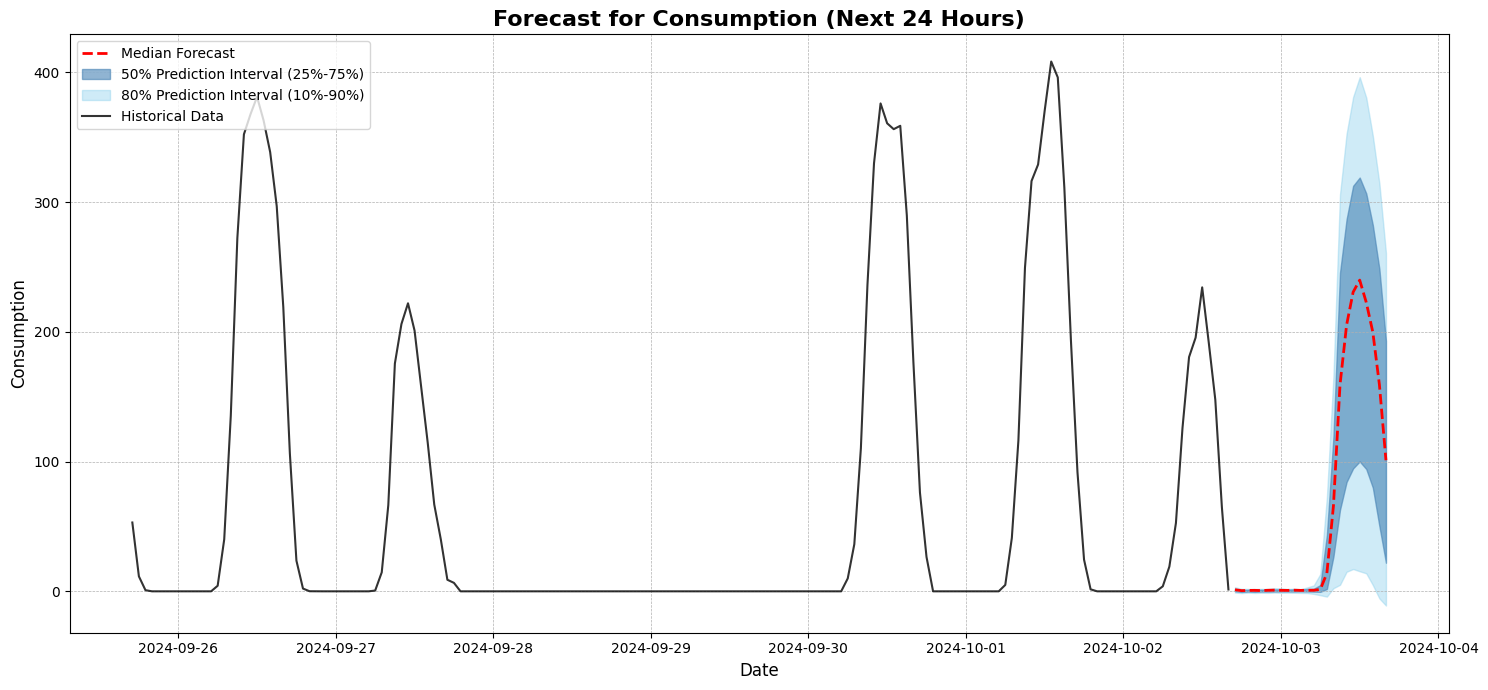


PREDICTING FUTURE FOR PRESENCE for 24 hours

Making predictions with context of 35982 samples...

Predictions:
                     median_forecast
2024-10-02 17:00:00         0.480000
2024-10-02 18:00:00         0.310000
2024-10-02 19:00:00         0.260000
2024-10-02 20:00:00         0.350000
2024-10-02 21:00:00         0.220000
2024-10-02 22:00:00         0.310000
2024-10-02 23:00:00         0.320000
2024-10-03 00:00:00         0.250000
2024-10-03 01:00:00         0.240000
2024-10-03 02:00:00         0.270000
2024-10-03 03:00:00         0.240000
2024-10-03 04:00:00         0.320000
2024-10-03 05:00:00         0.350000
2024-10-03 06:00:00         0.750000
2024-10-03 07:00:00         7.470000
2024-10-03 08:00:00        34.220001
2024-10-03 09:00:00        59.520000
2024-10-03 10:00:00        67.370003
2024-10-03 11:00:00        74.400002
2024-10-03 12:00:00        79.339996
2024-10-03 13:00:00        74.830002
2024-10-03 14:00:00        68.139999
2024-10-03 15:00:00        59.889999


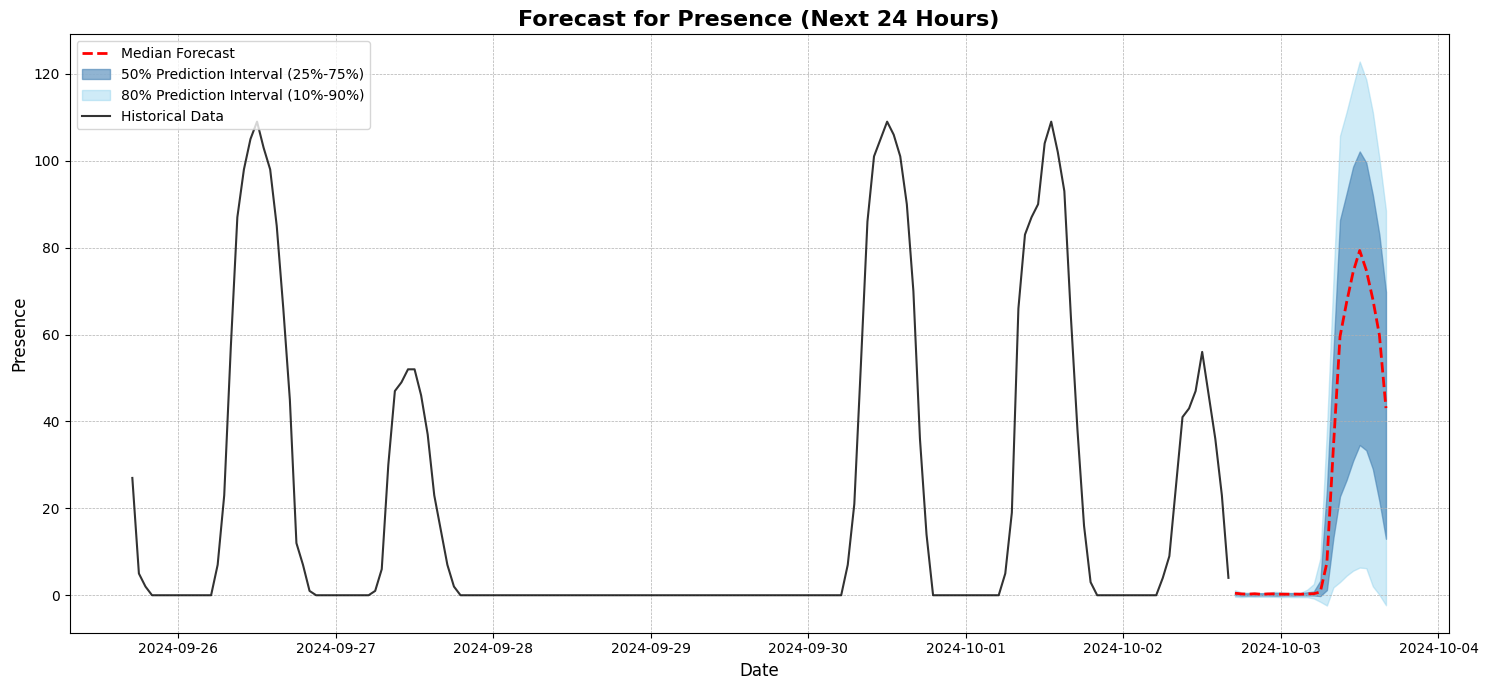

In [22]:
def predict_future_chronos2(ts_data, target_name, h_ahead=24):
    """Predicts future values using Chronos 2."""
    try:
        pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-2", device_map="cpu")
    except Exception as e:
        print(f"⚠️ Failed to load Chronos 2: {str(e)[:100]}")
        return None

    print(f"\n{'='*80}")
    print(f"PREDICTING FUTURE FOR {target_name.upper()} for {h_ahead} hours")
    print(f"{'='*80}\n")

    context_df = pd.DataFrame({
        'Date Time': ts_data.index,
        'item_id': 'ev_fleet',
        target_name: ts_data.values
    }).reset_index(drop=True)
    
    # Ensure correct datetime format
    context_df['Date Time'] = pd.to_datetime(context_df['Date Time'])

    try:
        print(f"Making predictions with context of {len(context_df)} samples...\n")
        
        cron_qs = [0.1, 0.25, 0.5, 0.75, 0.9]
        
        # Predict using the whole dataset as context
        future_predictions_df = pipeline.predict_df(
            context_df,
            prediction_length=h_ahead,
            quantile_levels=cron_qs,
            id_column="item_id",
            timestamp_column="Date Time",
            target=target_name
        )
        
        # Create a proper date range for the forecast
        start_forecast_date = ts_data.index[-1] + pd.Timedelta(hours=1)
        forecast_index = pd.date_range(start_forecast_date, periods=h_ahead, freq='h')
        
        # Set the index for the predictions
        future_predictions_df.index = forecast_index
        
        print("Predictions:")
        print(future_predictions_df[['0.5']].rename(columns={'0.5': 'median_forecast'}).round(2))
        
        return future_predictions_df

    except Exception as e:
        print(f"⚠️ Chronos 2 prediction failed: {str(e)[:150]}\n")
        return None

def plot_future_forecast(ts_data, forecast_df, target_name):
    """Plots historical data and the future forecast with clearer prediction intervals."""
    plt.figure(figsize=(15, 7))
    
    # Plot historical data (e.g., last week)
    plt.plot(ts_data.index, ts_data.values, label='Historical Data', color='black', alpha=0.8)
    
    # Plot 80% prediction interval (10% to 90% quantiles)
    plt.fill_between(forecast_df.index, 
                     forecast_df['0.1'], 
                     forecast_df['0.9'], 
                     color='skyblue', 
                     alpha=0.4, 
                     label='80% Prediction Interval (10%-90%)')
                     
    # Plot 50% prediction interval (25% to 75% quantiles)
    plt.fill_between(forecast_df.index, 
                     forecast_df['0.25'], 
                     forecast_df['0.75'], 
                     color='steelblue', 
                     alpha=0.6, 
                     label='50% Prediction Interval (25%-75%)')

    # Plot median forecast
    plt.plot(forecast_df.index, forecast_df['0.5'], label='Median Forecast', color='red', linestyle='--', linewidth=2)
    
    plt.title(f'Forecast for {target_name} (Next 24 Hours)', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel(target_name, fontsize=12)
    
    # Re-order legend handles to be more intuitive
    handles, labels = plt.gca().get_legend_handles_labels()
    # The order is based on the plotting sequence: Historical, 80% PI, 50% PI, Median
    # We want: Median, 50% PI, 80% PI, Historical
    order = [3, 2, 1, 0] 
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='upper left')
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    
# ============================================================================
# EXECUTION
# ============================================================================
# Predict for the next 24 hours after the last data point
print("\n" + "="*80)
print("FORECASTING NEXT 24 HOURS")
print("="*80)

# Predict for consumption
consumption_forecast_df = predict_future_chronos2(fleet_ts['consumption'], target_name='consumption', h_ahead=24)
if consumption_forecast_df is not None:
    # Plot last 7 days of history + 24h forecast
    plot_future_forecast(fleet_ts['consumption'][-168:], consumption_forecast_df, 'Consumption')

# Predict for presence
presence_forecast_df = predict_future_chronos2(fleet_ts['presence'], target_name='presence', h_ahead=24)
if presence_forecast_df is not None:
    # Plot last 7 days of history + 24h forecast
    plot_future_forecast(fleet_ts['presence'][-168:], presence_forecast_df, 'Presence')

# Conclusions